In [1]:
!pip install pyyaml h5py  # Required to save models in HDF5 format
!git clone https://github.com/Mahsarnzh/XDRL_power_plant

Cloning into 'XDRL_power_plant'...
remote: Enumerating objects: 224, done.
remote: Counting objects: 100% (145/145), done.
remote: Compressing objects: 100% (99/99), done.
remote: Total 224 (delta 58), reused 118 (delta 46), pack-reused 79
Receiving objects: 100% (224/224), 24.70 MiB | 12.95 MiB/s, done.
Resolving deltas: 100% (87/87), done.


In [2]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.7/535.7 kB 8.7 MB/s eta 0:00:00


In [3]:
import sys
import os
sys.path.append("/content/XDRL_power_plant/")

In [4]:
import shap

In [5]:
%cd /content/XDRL_power_plant

/content/XDRL_power_plant


In [6]:
import criticNet.model
import actorNet.model

In [7]:
import criticNet_env.model
import actorNet_env.model

In [8]:
model_actorNet = actorNet.load_model(os.path.join(os.path.dirname(actorNet.__file__), "weights.h5"))
model_criticNet = criticNet.load_model(os.path.join(os.path.dirname(criticNet.__file__), "weights.h5"))

In [10]:
model_actorNet_env = actorNet_env.load_model(os.path.join(os.path.dirname(actorNet_env.__file__), "weights.h5"))
model_criticNet_env = criticNet_env.load_model(os.path.join(os.path.dirname(criticNet_env.__file__), "weights.h5"))

In [11]:
! pip install onnx_tf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.1/226.1 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 39.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 55.1 MB/s eta 0:00:00


In [12]:
!pip install onnxruntime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 13.4 MB/s eta 0:00:00


In [13]:
import onnx
from matplotlib import pyplot as plt
from onnx_tf.backend import prepare
import tensorflow as tf
import numpy as np
import gym
from gym import spaces
import itertools
from gym.spaces import Box



TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 



In [14]:
actorNet_onnx_model = onnx.load("actorNet_Correct.onnx")  # load onnx model
tf_rep = prepare(actorNet_onnx_model)  # prepare tf representation
tf_rep.export_graph("output_path")

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
`mapping.TENSOR_TYPE_TO_NP_TYPE` is now deprecated and will be removed in a future release.To silence this warning, please use `helper.tensor_dtype_to_np_dtype` instead.


In [15]:
# Load the ONNX model
actorNet_onnx = onnx.load("actorNet_Correct.onnx")
# Prepare the ONNX model for TensorFlow
actorNet_onnx_model = prepare(actorNet_onnx)

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
`mapping.TENSOR_TYPE_TO_NP_TYPE` is now deprecated and will be removed in a future release.To silence this warning, please use `helper.tensor_dtype_to_np_dtype` instead.


In [16]:
class Nuc_Maint_Env_Proposal_220211_NPIC_MATLAB2022A(gym.Env):
    def __init__(self):
        self.NumComponents = 1
        self.MaxTime = 200
        self.RefuelPeriod = 18
        self.MaxInitialHealth = 0.9999
        self.MinInitialHealth = 0.8
        self.InitialHealthNoise = 0.01
        self.MinHealth = 0
        self.DegradationMean = 0.05
        self.DegradationVar = 0.1
        self.SensorNoiseVar = 0
        self.LeadTime = 5
        self.PenaltyForThirdCapacity = -40
        self.PenaltyForHalfCapacity = -60
        self.PenaltyForNotOperating = -100
        self.CostToRepair = -10
        self.CostToReplace = -5
        self.CostToOrder = -15
        self.CostInventory = -1

        self.ObservationInfo = spaces.Box(low=-np.inf, high=np.inf, shape=(5, 1), dtype=np.float32)

        elements = np.array([[0, 0], [1, 0], [2, 0], [0, 1], [1, 1], [2, 1]])

        ActionInfo = elements.tolist()
        self.ActionInfo = ActionInfo

        self.IsDone = 0

    def step(self, action):
        MaintDecision1 = action[0]
        OrderPart1 = action[1]

        Month = self.State[0]
        Component1 = self.State[1]
        Inv1 = self.State[2]
        ArrivalDate1 = self.State[3]
        PartReplaced1 = self.State[4]

        Month += 1
        PartReplaced1 = 0

        if MaintDecision1 == 2 and Inv1 > 0:  # Replace
            Inv1 -= 1
            Component1 = self.MaxInitialHealth - np.random.gamma(self.InitialHealthNoise)
            PartReplaced1 = 1

            if Component1 < self.MinInitialHealth:
                Component1 = self.MinInitialHealth

        elif MaintDecision1 == 1:  # Repair
            Component1 += (self.MaxInitialHealth - Component1) * 0.1  # about 10 percent increase in health gap



        if Month%(self.RefuelPeriod) != 0:
            Component1 -= np.abs(self.DegradationMean + self.DegradationVar * np.random.randn()) * (1 - Component1)


        if Component1 == 0:
            Sensor1 = 0  # self-announcing failure
        else:
            Sensor1 = Component1 + self.SensorNoiseVar * np.random.randn()
            if Sensor1 > 1:
              Sensor1 = min(Sensor1, 1)
            elif Sensor1 < 0:
              Sensor1 = max(Sensor1,0)
            Sensor1 = max(min(Sensor1, 1), 0)

        if Month % self.RefuelPeriod == 0:
            DaysToShutdown = 0
        else:
            DaysToShutdown = (self.RefuelPeriod - Month%(self.RefuelPeriod)) / self.RefuelPeriod


        ArrivalDate1 = [x - 1 for x in ArrivalDate1]

        if len(ArrivalDate1) > 0:
            if ArrivalDate1[0] == 0:
                Inv1 += 1  # Add part to inventory
                ArrivalDate1 = [x for x in ArrivalDate1 if x > 0]  # Remove countdown from backlog



        if OrderPart1:
            ArrivalDate1 = np.append(ArrivalDate1, self.LeadTime)

        if len(ArrivalDate1) > 0:
            OnOrder1 = ArrivalDate1[0] / self.LeadTime
        else:
            OnOrder1 = 0

        InvNorm1 = Inv1 / 200
        InvFlag1 = int(np.any(Inv1 > 0))

        self.State = np.array([Month, Component1, Inv1, ArrivalDate1, PartReplaced1] , dtype=object)

        observation = np.array([DaysToShutdown, Sensor1, InvNorm1, InvFlag1, OnOrder1])

        self.IsDone = 0
        reward = self.get_reward(self.State, action)
        return observation, reward, self.IsDone, {}

    def reset(self):
        Component1 = self.MaxInitialHealth - 0.05 * np.random.rand()
        Sensor1 = Component1 + self.SensorNoiseVar * np.random.randn()
        Sensor1 = max(min(Sensor1, 1), 0)
        Inv1 = 0
        InvNorm1 = Inv1 / 200
        InvFlag1 = int(Inv1 > 0)
        ArrivalDate1 = []
        OnOrder1 = 0
        PartReplaced1 = 0
        Month = 1

        if Month%(self.RefuelPeriod) == 0:
            DaysToShutdown = 0
        else:
            DaysToShutdown = (self.RefuelPeriod - (Month%self.RefuelPeriod)) / self.RefuelPeriod

        initial_observation = np.array([DaysToShutdown, Sensor1, InvNorm1, InvFlag1, OnOrder1])
        initial_observation = tf.ragged.constant(initial_observation)

        self.State = np.array([Month, Component1, Inv1, ArrivalDate1, PartReplaced1], dtype=object)

        return initial_observation

    def get_reward(self, State, Action):
        Month = State[0]
        Sensor1 = State[1]
        Inv1 = State[2]
        PartReplaced1 = State[4]

        Action1 = Action[0]
        OrderPart1 = Action[1]

        reward = 0

        if Inv1 > 0:
            reward += self.CostInventory * Inv1

        reward += self.CostToOrder * OrderPart1

        if Sensor1 == 0 and Month % self.RefuelPeriod != 0:
            reward += 2 * self.PenaltyForHalfCapacity
        elif PartReplaced1 and Month % self.RefuelPeriod != 0:
            reward += 2 * self.PenaltyForHalfCapacity

        if Action1 == 1:
            reward += self.CostToRepair
        elif PartReplaced1:
            reward += self.CostToReplace

        return reward


In [17]:
# import tensorflow as tf
env = Nuc_Maint_Env_Proposal_220211_NPIC_MATLAB2022A()

discount_factor = 0.999
max_steps_per_episode = 300

# Define the optimization algorithms for actor and critic networks
actor_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
critic_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

mtrx_max_act_idx = np.zeros((max_steps_per_episode, 2))
action_index_ = []
action_max_prob_ = []
action_probs_arr = []
actor = model_actorNet_env
critic = model_criticNet_env
state_tensors = []
episode_rewards = []
actionss = []
num_episodes = 1
for episode in range(num_episodes):
    state = env.reset()
    episode_reward = 0

    # with tf.GradientTape(persistent=True) as tape:
    for t in range(max_steps_per_episode):

        state_tensor = tf.convert_to_tensor(state)
        state_tensor_ = tf.expand_dims(state_tensor, 0)

        input_data = tf.cast(state_tensor_, dtype=tf.float32)
        # Create input tensor
        input_data = tf.constant(input_data, dtype=tf.float32)
        state_tensors.append(input_data)


        # Get action probabilities from actor network
        action_probs = actorNet_onnx_model.run(input_data)
        action_probs_arr.append(action_probs)

        action_max_prob = np.array([action_probs])
        max_value = np.max(action_max_prob)
        action_max_prob_.append(max_value)

        # Sample an action from the action probabilities
        action_log_prob = tf.argmax(action_probs, axis=-1)
        # print(action_log_prob)
        action_index = action_log_prob.numpy().item()
        action_index_.append(action_index)



        # action_log_prob = torch.argmax(action_logits)

        actionelements = np.array([[0, 0], [1, 0], [2, 0], [0, 1], [1, 1], [2, 1]])


        # Retrieve the corresponding action

        action = actionelements[action_index]
        # action_max_prob =


        actionss.append(action)

        # Take the action in the environment
        state, reward, done, _ = env.step(action)

        episode_reward += reward
        episode_rewards.append(episode_reward)  # Save state_tensor to the list

        if done:
            break

    mtrx_max_act_idx[:,0] = action_max_prob_
    mtrx_max_act_idx[:,1] = action_index_
    state_log_ = tf.squeeze(state_tensors)
    action_log_ = tf.squeeze(actionss)
    state_log_ = np.array(state_log_)
    action_log_ = np.array(action_log_)

    state_log = np.array(state_tensors)
    action_log = np.array(actionss)

    t_values = np.arange(num_episodes)  # Generate an array of indices from 0 to max_steps_per_episode


In [18]:
locations = np.where(np.all(action_log == [1, 0], axis=1))
locations

(array([], dtype=int64),)

In [19]:
# Maintenance actions available [0,0; 1,0;  2,0;  0,1;  1,1;  2,1;]

In [20]:
action_probs_arr[141]

Outputs(RepresentationSoftMax=array([[9.99821484e-01, 1.75963447e-04, 1.09616565e-08, 1.11134545e-06,
        1.30986137e-07, 1.46302625e-06]], dtype=float32))

In [21]:
action_log[141]

array([0, 0])

Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.


<Figure size 640x480 with 0 Axes>

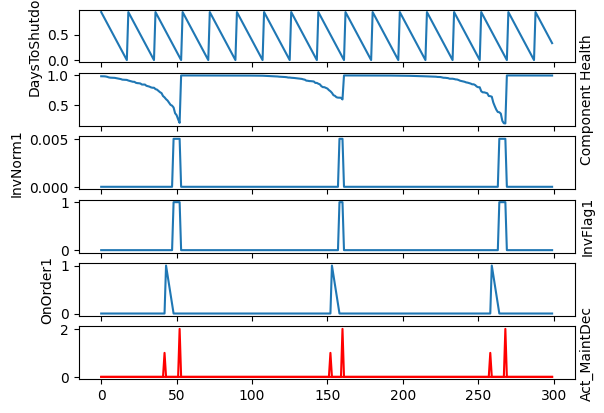

In [22]:
plt.figure()
axs = plt.subplots(sharex=True, sharey=False)

plt.subplot(611), plt.plot(state_log[:,0,0]), plt.ylabel('DaysToShutdown')

plt.subplot(612), plt.plot(state_log[:,0,1]), plt.ylabel('Component Health')
plt.subplot(612).yaxis.set_label_position('right')

plt.subplot(613), plt.plot(state_log[:,0,2]), plt.ylabel('InvNorm1')

plt.subplot(614), plt.plot(state_log[:,0,3]), plt.ylabel('InvFlag1')
plt.subplot(614).yaxis.set_label_position('right')

plt.subplot(615), plt.plot(state_log[:,0,4]), plt.ylabel('OnOrder1')

plt.subplot(616), plt.plot(action_log, 'r'), plt.ylabel('Act_MaintDec')
plt.subplot(616).yaxis.set_label_position('right')

# plt.subplot(616), plt.plot(action_log[:,0], 'r'), plt.ylabel('Ac(0)_MaintDec')
# plt.subplot(616), plt.plot(action_log[:,1], 'r'), plt.ylabel('Act(1)_OrderPart')


# The code cell below imports the model, creates the environment, stepps through the environment and prints the chosen actions of [1,0]

In [23]:
# Load the ONNX model
actorNet_onnx = onnx.load("actorNet_Correct.onnx")
# Prepare the ONNX model for TensorFlow
actorNet_onnx_model = prepare(actorNet_onnx)


class Nuc_Maint_Env_Proposal_220211_NPIC_MATLAB2022A(gym.Env):
    def __init__(self):
        self.NumComponents = 1
        self.MaxTime = 200
        self.RefuelPeriod = 18
        self.MaxInitialHealth = 0.9999
        self.MinInitialHealth = 0.8
        self.InitialHealthNoise = 0.01
        self.MinHealth = 0
        self.DegradationMean = 0.05
        self.DegradationVar = 0.1
        self.SensorNoiseVar = 0
        self.LeadTime = 5
        self.PenaltyForThirdCapacity = -40
        self.PenaltyForHalfCapacity = -60
        self.PenaltyForNotOperating = -100
        self.CostToRepair = -10
        self.CostToReplace = -5
        self.CostToOrder = -15
        self.CostInventory = -1

        self.ObservationInfo = spaces.Box(low=-np.inf, high=np.inf, shape=(5, 1), dtype=np.float32)

        elements = np.array([[0, 0], [1, 0], [2, 0], [0, 1], [1, 1], [2, 1]])

        ActionInfo = elements.tolist()
        self.ActionInfo = ActionInfo

        self.IsDone = 0

    def step(self, action):
        MaintDecision1 = action[0]
        OrderPart1 = action[1]

        Month = self.State[0]
        Component1 = self.State[1]
        Inv1 = self.State[2]
        ArrivalDate1 = self.State[3]
        PartReplaced1 = self.State[4]

        Month += 1
        PartReplaced1 = 0

        if MaintDecision1 == 2 and Inv1 > 0:  # Replace
            Inv1 -= 1
            Component1 = self.MaxInitialHealth - np.random.gamma(self.InitialHealthNoise)
            PartReplaced1 = 1

            if Component1 < self.MinInitialHealth:
                Component1 = self.MinInitialHealth

        elif MaintDecision1 == 1:  # Repair
            Component1 += (self.MaxInitialHealth - Component1) * 0.1  # about 10 percent increase in health gap



        if Month%(self.RefuelPeriod) != 0:
            Component1 -= np.abs(self.DegradationMean + self.DegradationVar * np.random.randn()) * (1 - Component1)


        if Component1 == 0:
            Sensor1 = 0  # self-announcing failure
        else:
            Sensor1 = Component1 + self.SensorNoiseVar * np.random.randn()
            if Sensor1 > 1:
              Sensor1 = min(Sensor1, 1)
            elif Sensor1 < 0:
              Sensor1 = max(Sensor1,0)
            Sensor1 = max(min(Sensor1, 1), 0)

        if Month % self.RefuelPeriod == 0:
            DaysToShutdown = 0
        else:
            DaysToShutdown = (self.RefuelPeriod - Month%(self.RefuelPeriod)) / self.RefuelPeriod


        ArrivalDate1 = [x - 1 for x in ArrivalDate1]

        if len(ArrivalDate1) > 0:
            if ArrivalDate1[0] == 0:
                Inv1 += 1  # Add part to inventory
                ArrivalDate1 = [x for x in ArrivalDate1 if x > 0]  # Remove countdown from backlog



        if OrderPart1:
            ArrivalDate1 = np.append(ArrivalDate1, self.LeadTime)

        if len(ArrivalDate1) > 0:
            OnOrder1 = ArrivalDate1[0] / self.LeadTime
        else:
            OnOrder1 = 0

        InvNorm1 = Inv1 / 200
        InvFlag1 = int(np.any(Inv1 > 0))

        self.State = np.array([Month, Component1, Inv1, ArrivalDate1, PartReplaced1] , dtype=object)

        observation = np.array([DaysToShutdown, Sensor1, InvNorm1, InvFlag1, OnOrder1])

        self.IsDone = 0
        reward = self.get_reward(self.State, action)
        return observation, reward, self.IsDone, {}

    def reset(self):
        Component1 = self.MaxInitialHealth - 0.05 * np.random.rand()
        Sensor1 = Component1 + self.SensorNoiseVar * np.random.randn()
        Sensor1 = max(min(Sensor1, 1), 0)
        Inv1 = 0
        InvNorm1 = Inv1 / 200
        InvFlag1 = int(Inv1 > 0)
        ArrivalDate1 = []
        OnOrder1 = 0
        PartReplaced1 = 0
        Month = 1

        if Month%(self.RefuelPeriod) == 0:
            DaysToShutdown = 0
        else:
            DaysToShutdown = (self.RefuelPeriod - (Month%self.RefuelPeriod)) / self.RefuelPeriod

        initial_observation = np.array([DaysToShutdown, Sensor1, InvNorm1, InvFlag1, OnOrder1])
        initial_observation = tf.ragged.constant(initial_observation)

        self.State = np.array([Month, Component1, Inv1, ArrivalDate1, PartReplaced1], dtype=object)

        return initial_observation

    def get_reward(self, State, Action):
        Month = State[0]
        Sensor1 = State[1]
        Inv1 = State[2]
        PartReplaced1 = State[4]

        Action1 = Action[0]
        OrderPart1 = Action[1]

        reward = 0

        if Inv1 > 0:
            reward += self.CostInventory * Inv1

        reward += self.CostToOrder * OrderPart1

        if Sensor1 == 0 and Month % self.RefuelPeriod != 0:
            reward += 2 * self.PenaltyForHalfCapacity
        elif PartReplaced1 and Month % self.RefuelPeriod != 0:
            reward += 2 * self.PenaltyForHalfCapacity

        if Action1 == 1:
            reward += self.CostToRepair
        elif PartReplaced1:
            reward += self.CostToReplace

        return reward

# import tensorflow as tf
env = Nuc_Maint_Env_Proposal_220211_NPIC_MATLAB2022A()

discount_factor = 0.999
max_steps_per_episode = 300

# Define the optimization algorithms for actor and critic networks
actor_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
critic_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

mtrx_max_act_idx = np.zeros((max_steps_per_episode, 2))
action_index_ = []
action_max_prob_ = []
action_probs_arr = []
actor = model_actorNet_env
critic = model_criticNet_env
state_tensors = []
episode_rewards = []
actionss = []
num_episodes = 1
for episode in range(num_episodes):
    state = env.reset()
    episode_reward = 0

    # with tf.GradientTape(persistent=True) as tape:
    for t in range(max_steps_per_episode):

        state_tensor = tf.convert_to_tensor(state)
        state_tensor_ = tf.expand_dims(state_tensor, 0)

        input_data = tf.cast(state_tensor_, dtype=tf.float32)
        # Create input tensor
        input_data = tf.constant(input_data, dtype=tf.float32)
        state_tensors.append(input_data)


        # Get action probabilities from actor network
        action_probs = actorNet_onnx_model.run(input_data)
        action_probs_arr.append(action_probs)

        action_max_prob = np.array([action_probs])
        max_value = np.max(action_max_prob)
        action_max_prob_.append(max_value)

        # Sample an action from the action probabilities
        action_log_prob = tf.argmax(action_probs, axis=-1)
        # print(action_log_prob)
        action_index = action_log_prob.numpy().item()
        action_index_.append(action_index)



        # action_log_prob = torch.argmax(action_logits)

        actionelements = np.array([[0, 0], [1, 0], [2, 0], [0, 1], [1, 1], [2, 1]])


        # Retrieve the corresponding action

        action = actionelements[action_index]
        # action_max_prob =


        actionss.append(action)

        # Take the action in the environment
        state, reward, done, _ = env.step(action)

        episode_reward += reward
        episode_rewards.append(episode_reward)  # Save state_tensor to the list

        if done:
            break

    mtrx_max_act_idx[:,0] = action_max_prob_
    mtrx_max_act_idx[:,1] = action_index_
    state_log_ = tf.squeeze(state_tensors)
    action_log_ = tf.squeeze(actionss)
    state_log_ = np.array(state_log_)
    action_log_ = np.array(action_log_)

    state_log = np.array(state_tensors)
    action_log = np.array(actionss)

    t_values = np.arange(num_episodes)  # Generate an array of indices from 0 to max_steps_per_episode
locations = np.where(np.all(action_log == [1, 0], axis=1))
locations

(array([], dtype=int64),)

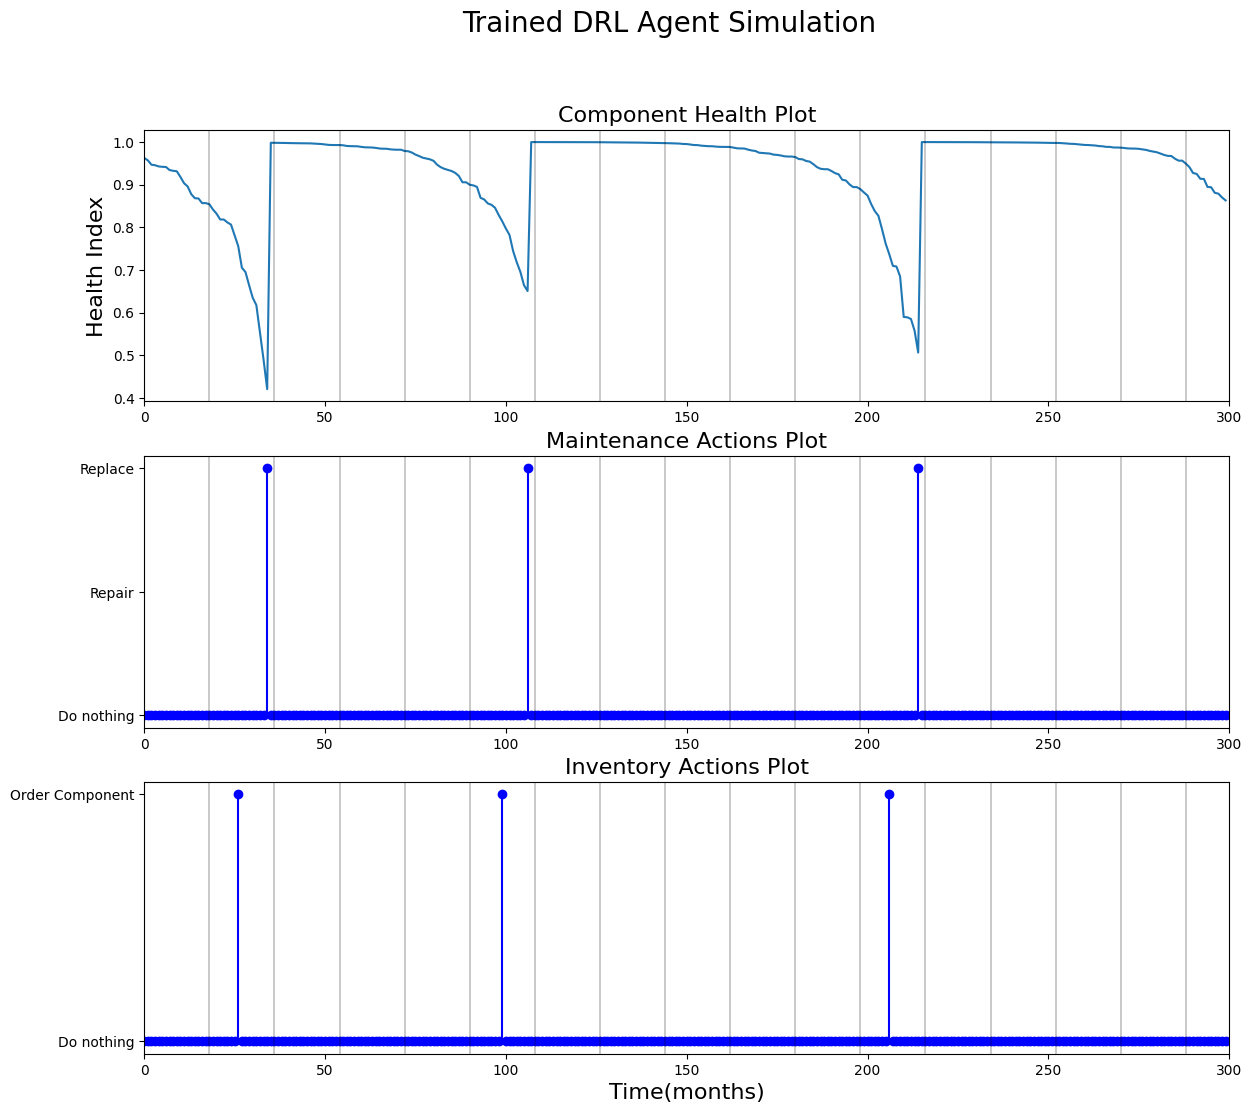

In [24]:
# Create a figure with a larger size
f = plt.figure(figsize=(14, 12))

# Create the subplots and share the y-axis
ax1 = plt.subplot(311)
ax2 = plt.subplot(312)
ax3 = plt.subplot(313)

ax1.plot(state_log[:, 0, 1])
ax1.set_ylabel('Health Index', fontsize=16)
ax1.set_title('Component Health Plot', fontsize=16)

ax2.stem(action_log[:, 0], linefmt='b-', markerfmt='bo', basefmt=' ')
ax2.set_yticks([0, 1, 2])  # Define custom ticks
ax2.set_yticklabels(['Do nothing', 'Repair', 'Replace'])  # Define custom tick labels
ax2.set_title('Maintenance Actions Plot', fontsize=16)  # Add a title to ax2

ax3.stem(action_log[:, 1], linefmt='b-', markerfmt='bo', basefmt=' ')
ax3.set_yticks([0, 1])  # Define custom ticks
ax3.set_yticklabels(['Do nothing', 'Order Component'])  # Define custom tick labels
ax3.set_title('Inventory Actions Plot', fontsize=16)  # Add a title to ax3


interval = 18
vertical_lines_positions = range(0, len(state_log), interval)  # Start from 1 and then continue at intervals of 18
for position in vertical_lines_positions:
    ax1.axvline(x=position, color='black', linestyle='-', linewidth=0.3)
    ax2.axvline(x=position, color='black', linestyle='-', linewidth=0.3)
    ax3.axvline(x=position, color='black', linestyle='-', linewidth=0.3)


# Adjust label positions
ax1.yaxis.set_label_position('left')
ax2.yaxis.set_label_position('left')
ax3.yaxis.set_label_position('left')


ax1.set_xlim(0, len(state_log))  # Set x-axis limit to start from zero
ax2.set_xlim(0, len(action_log))  # Set x-axis limit to start from zero
ax3.set_xlim(0, len(action_log))  # Set x-axis limit to start from zero



# Add labels for the x-axis and a title if needed
plt.xlabel('Time(months)', fontsize=16)
plt.suptitle('Trained DRL Agent Simulation', fontsize=20)

# Show the plot
plt.show()

# Saves the state log and action log as a csv file

In [25]:
# reshaped_array = state_log.reshape(300, 5)
# state_log_df = pd.DataFrame(reshaped_array)
# action_log_df = pd.DataFrame(action_log)

# # Save DataFrames to CSV files
# state_log_df.to_csv("state_log.csv", index=False, header=False)
# action_log_df.to_csv("action_log.csv", index=False, header=False)

In [26]:
# f.savefig("Simulation.png", bbox_inches='tight', dpi=1000)

# The saved final version of data.csv plots, uncomment to run

In [27]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

# Read the CSV file
state_log = pd.read_csv("state_log.csv")
action_log =  pd.read_csv("action_log.csv")

state_log = state_log.to_numpy()
action_log = action_log.to_numpy()


In [28]:
# Assuming state_log is a NumPy array
new_row = state_log[0]
state_log = np.vstack([new_row, state_log])
new_row_action = action_log[0]

action_log = np.vstack([new_row_action, action_log])


`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [29]:
state_log.shape

(300, 5)

In [30]:
action_log.shape

(300, 2)

In [31]:
locations = np.where(np.all(action_log == [1, 0], axis=1))
locations

(array([51]),)

In [32]:
# Maintenance actions available [0,0; 1,0;  2,0;  0,1;  1,1;  2,1;]

In [33]:
action_probs_arr[51]

Outputs(RepresentationSoftMax=array([[9.9997783e-01, 2.2207394e-05, 6.7993278e-10, 2.4155742e-09,
        3.2835736e-09, 2.3287944e-08]], dtype=float32))

In [34]:
action_log[141]

array([0, 0])

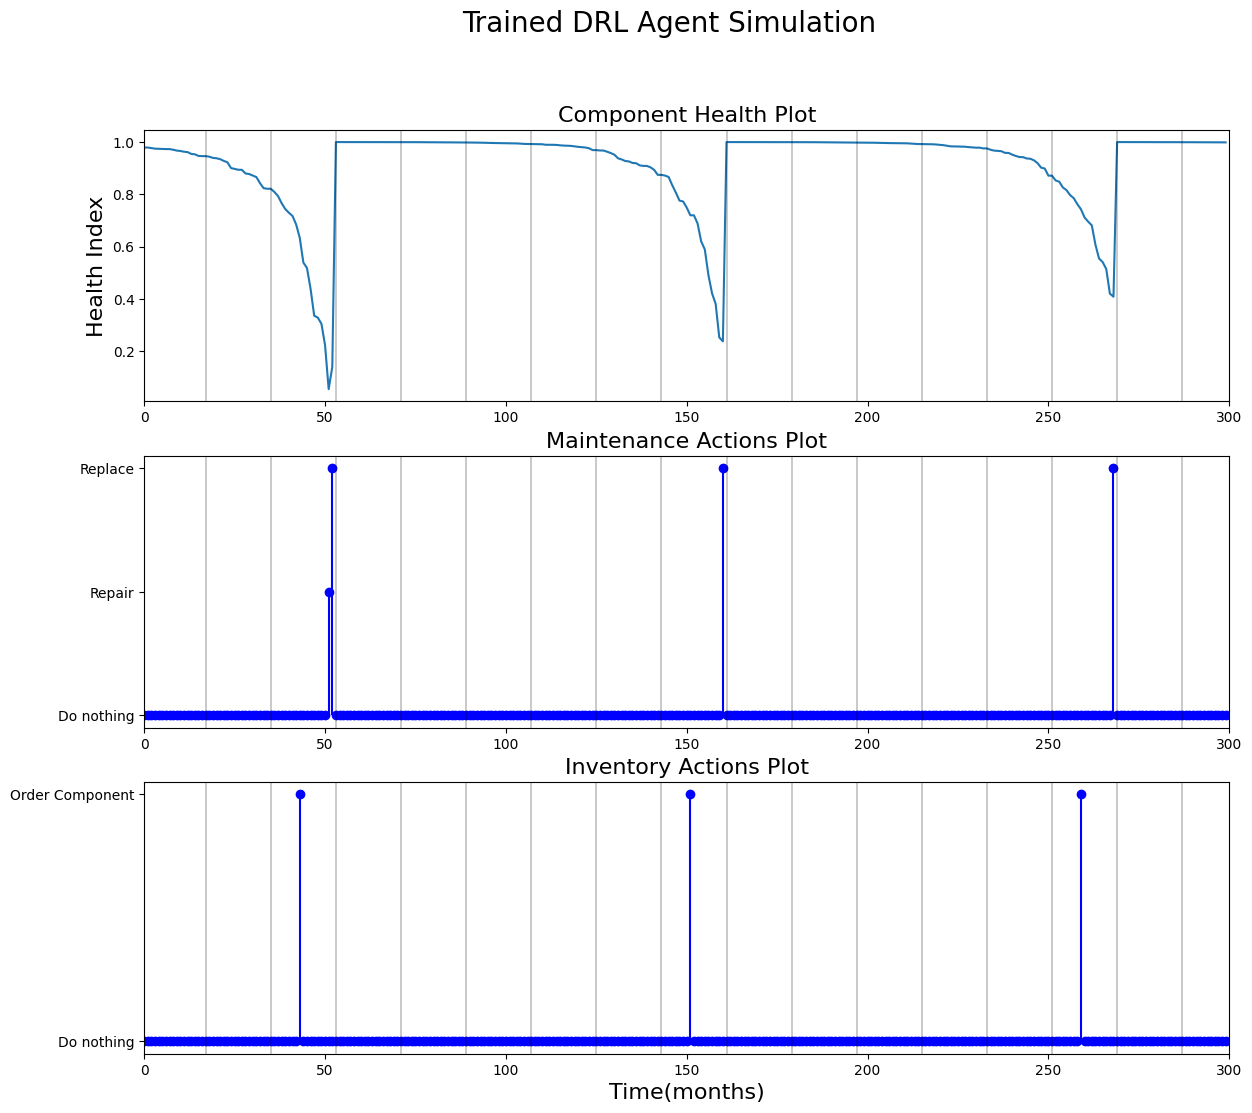

In [35]:
# Create a figure with a larger size
f = plt.figure(figsize=(14, 12))

# Create the subplots and share the y-axis
ax1 = plt.subplot(311)
ax2 = plt.subplot(312)
ax3 = plt.subplot(313)

ax1.plot(state_log[:, 1])
ax1.set_ylabel('Health Index', fontsize=16)
ax1.set_title('Component Health Plot', fontsize=16)

ax2.stem(action_log[:, 0], linefmt='b-', markerfmt='bo', basefmt=' ')
ax2.set_yticks([0, 1, 2])  # Define custom ticks
ax2.set_yticklabels(['Do nothing', 'Repair', 'Replace'])  # Define custom tick labels
ax2.set_title('Maintenance Actions Plot', fontsize=16)  # Add a title to ax2

ax3.stem(action_log[:, 1], linefmt='b-', markerfmt='bo', basefmt=' ')
ax3.set_yticks([0, 1])  # Define custom ticks
ax3.set_yticklabels(['Do nothing', 'Order Component'])  # Define custom tick labels
ax3.set_title('Inventory Actions Plot', fontsize=16)  # Add a title to ax3




start_position = 18
interval = 18
vertical_lines_positions = range(start_position-1, len(state_log), interval)  # Start from 17 and then continue at intervals of 18
for position in vertical_lines_positions:
    ax1.axvline(x=position, color='black', linestyle='-', linewidth=0.3)
    ax2.axvline(x=position, color='black', linestyle='-', linewidth=0.3)
    ax3.axvline(x=position, color='black', linestyle='-', linewidth=0.3)



# Adjust label positions
ax1.yaxis.set_label_position('left')
ax2.yaxis.set_label_position('left')
ax3.yaxis.set_label_position('left')


ax1.set_xlim(0, len(state_log))  # Set x-axis limit to start from zero
ax2.set_xlim(0, len(action_log))  # Set x-axis limit to start from zero
ax3.set_xlim(0, len(action_log))  # Set x-axis limit to start from zero



# Add labels for the x-axis and a title if needed
plt.xlabel('Time(months)', fontsize=16)
plt.suptitle('Trained DRL Agent Simulation', fontsize=20)

# Show the plot
plt.show()

In [36]:
# f.savefig("Simulation.png", bbox_inches='tight', dpi=1000)

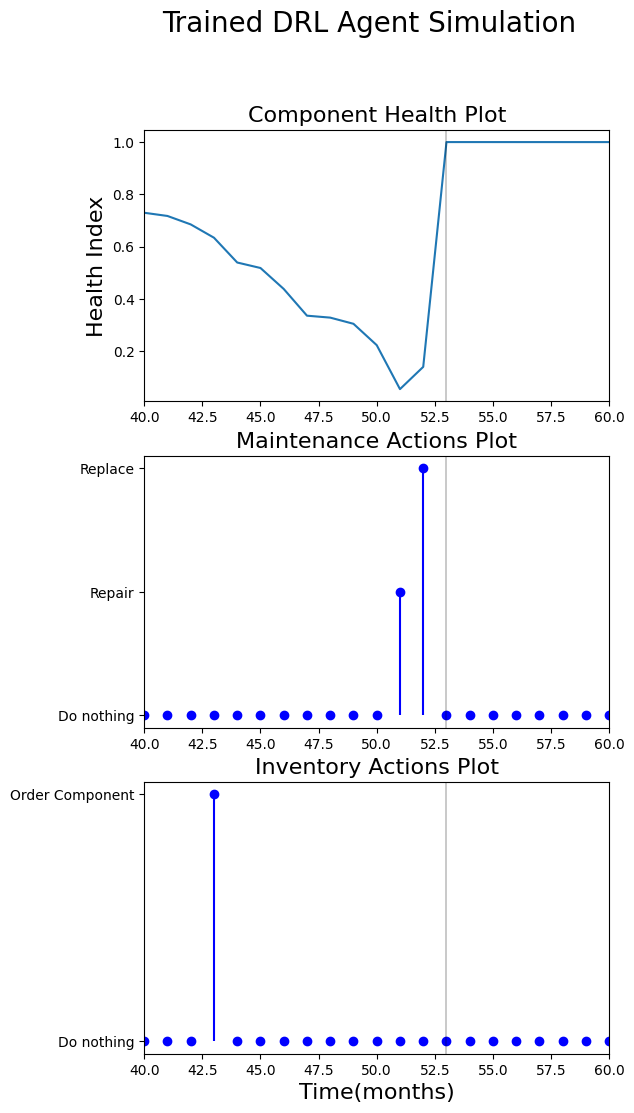

In [37]:
# Create a figure with a larger size
f = plt.figure(figsize=(6, 12))

# Create the subplots and share the y-axis
ax1 = plt.subplot(311)
ax2 = plt.subplot(312)
ax3 = plt.subplot(313)

ax1.plot(range(40, 61), state_log[40:61, 1])

ax1.set_ylabel('Health Index', fontsize=16)
ax1.set_title('Component Health Plot', fontsize=16)

ax2.stem(range(40, 61), action_log[40:61, 0], linefmt='b-', markerfmt='bo', basefmt=' ')

ax2.set_yticks([0, 1, 2])  # Define custom ticks
ax2.set_yticklabels(['Do nothing', 'Repair', 'Replace'])  # Define custom tick labels
ax2.set_title('Maintenance Actions Plot', fontsize=16)  # Add a title to ax2

ax3.stem(range(40, 61), action_log[40:61, 1], linefmt='b-', markerfmt='bo', basefmt=' ')

ax3.set_yticks([0, 1])  # Define custom ticks
ax3.set_yticklabels(['Do nothing', 'Order Component'])  # Define custom tick labels
ax3.set_title('Inventory Actions Plot', fontsize=16)  # Add a title to ax3


start_position = 18
interval = 18
vertical_lines_positions = range(start_position-1, len(state_log), interval)  # Start from 17 and then continue at intervals of 18
for position in vertical_lines_positions:
    ax1.axvline(x=position, color='black', linestyle='-', linewidth=0.3)
    ax2.axvline(x=position, color='black', linestyle='-', linewidth=0.3)
    ax3.axvline(x=position, color='black', linestyle='-', linewidth=0.3)


# Adjust label positions
ax1.yaxis.set_label_position('left')
ax2.yaxis.set_label_position('left')
ax3.yaxis.set_label_position('left')

ax1.set_xlim(40, 60)
ax2.set_xlim(40, 60)
ax3.set_xlim(40, 60)


# Add labels for the x-axis and a title if needed
plt.xlabel('Time(months)', fontsize=16)
plt.suptitle('Trained DRL Agent Simulation', fontsize=20)

# Show the plot
plt.show()

# The other

In [38]:
def model_predict_Max(data):
    inputs = {actorNet_onnx_model.inputs[0]: data}
    outputs = actorNet_onnx_model.run(inputs)
    max_values = np.max(outputs[0], axis=-1)
    return max_values


In [39]:
# # Define the names of the states
# feature_names=['Months until \nthe Outage', 'Health of the Component', 'Inventory amount', 'Inventory Availability Flag(0 or 1)', 'Component \nDelivery Time']

In [40]:
# Define the names of the states
feature_names=['Months until Outage', 'Component Health', 'Inventory Quantity', 'Inventory Availability', 'Component Delivery Time']

In [41]:
def model_predict(data):
    inputs = {actorNet_onnx_model.inputs[0]: data}
    outputs = actorNet_onnx_model.run(inputs)

    return outputs[0]

In [42]:
import pandas as pd
reshaped_array = state_log.reshape(300, 5)
state_table = pd.DataFrame(reshaped_array, columns=feature_names)
state_log_reshaped = state_table

# In Case calculating SHAP for the saved csv files

In [43]:
import pandas as pd
reshaped_array = state_log

state_table = pd.DataFrame(reshaped_array, columns=feature_names)
state_log_reshaped = state_table

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [44]:
state_log_reshaped=state_log_reshaped.astype(np.float32)
state_table =state_table.astype(np.float32)

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [45]:
model_predict(state_table)[32]

array([9.9884707e-01, 9.1807422e-04, 1.1274232e-07, 1.8560355e-04,
       2.7019325e-06, 4.6381600e-05], dtype=float32)

In [46]:
model_pred_negative = np.where(np.all(model_predict(state_table) < 0, axis=1))
model_pred_negative

(array([], dtype=int64),)

In [47]:
# state_log_reshaped = state_table.reshape(state_table.shape[0], -1)
explainer = shap.KernelExplainer(model_predict, state_table)
shap_values = explainer.shap_values(state_table)

  0%|          | 0/300 [00:00<?, ?it/s]

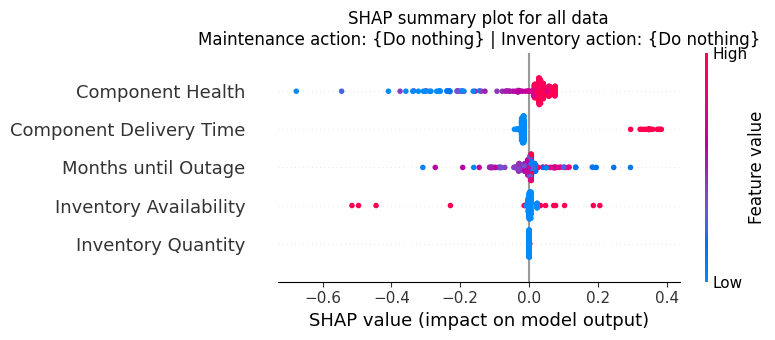

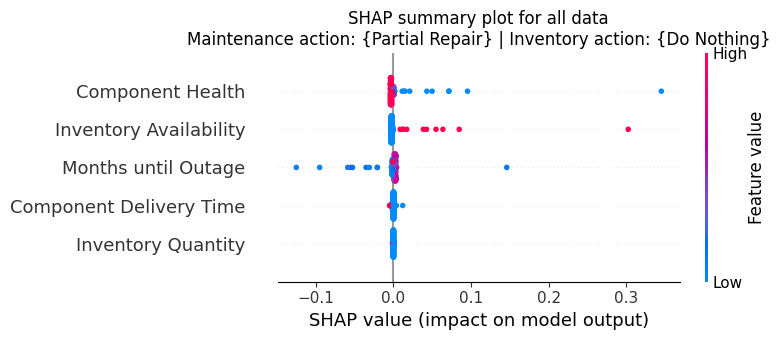

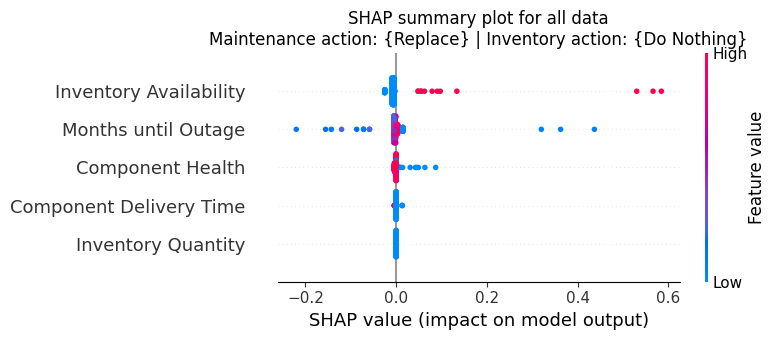

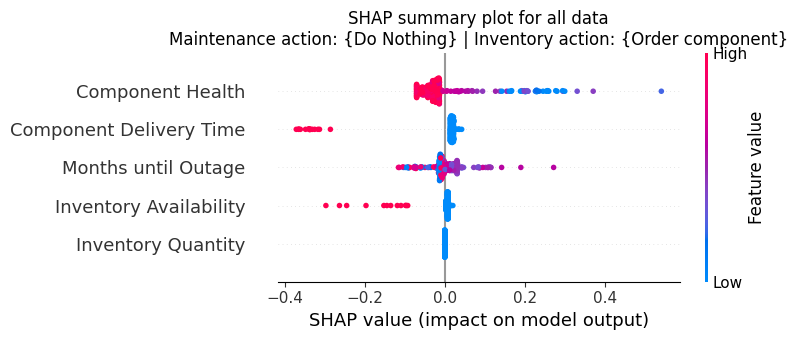

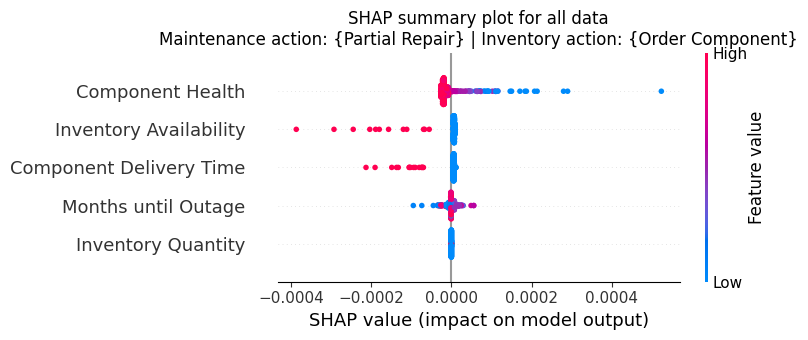

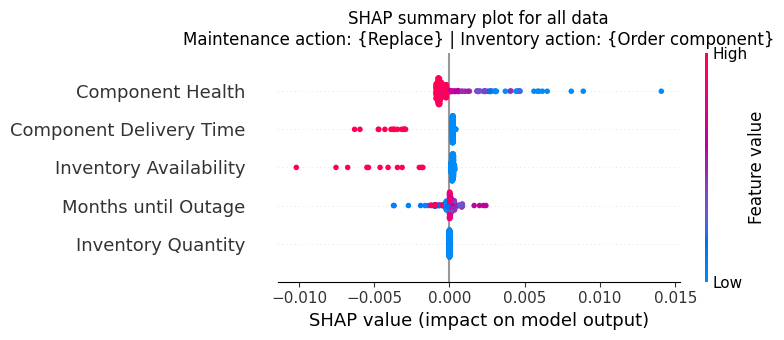

In [48]:
# Maintenance actions available [0,0; 1,0;  2,0;  0,1;  1,1;  2,1;]


class_names = ["\nMaintenance action: {Do nothing} | Inventory action: {Do nothing}",
               "\nMaintenance action: {Partial Repair} | Inventory action: {Do Nothing}",
               "\nMaintenance action: {Replace} | Inventory action: {Do Nothing}",
               "\nMaintenance action: {Do Nothing} | Inventory action: {Order component}",
               "\nMaintenance action: {Partial Repair} | Inventory action: {Order Component}",
               "\nMaintenance action: {Replace} | Inventory action: {Order component}"]

shap_values_ = np.array(shap_values)
for i in range(shap_values_.shape[0]):
  # shap.summary_plot(shap_values[i], state_table, color_bar_label='{}'.format(class_names[i]))
  f = plt.figure()

  plt.title("SHAP summary plot for all data"+ class_names[i] )  # Replace with your desired title

  plt.show(shap.summary_plot(shap_values[i], state_table))
  f.savefig(
      "SHAP_{class_name}.png".format(class_name=i),
      bbox_inches='tight', dpi=1200
  )





# Lime

In [49]:
# def make_LIME(trainingData, testingData, Qual, net):
#   instance_to_exp = st.slider("Select the Intance you would like LIME to Explain", min_value= 0, max_value=(testingData.shape[0] - 1), step=1, value=2)

#   feature_names = list(Qual.columns)

#   # Fit the Explainer on the training data set using the LimeTabularExplainer
#   explainer = LimeTabularExplainer(trainingData.values, feature_names =
#                                    feature_names,
#                                    mode = 'regression')
#   explanation = explainer.explain_instance(testingData.values[instance_to_exp], net.predict, labels=(0, 1))
#   st.pyplot(explanation.as_pyplot_figure())

# SHAP Waterfall

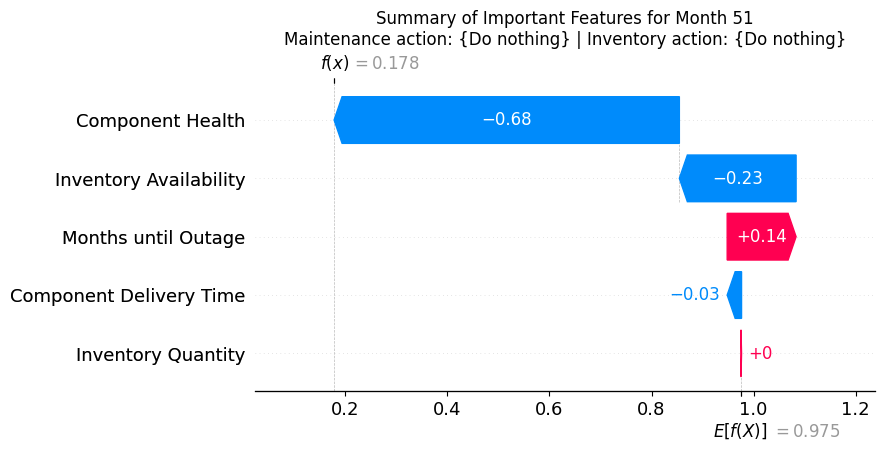

In [50]:
# Maintenance actions available [0,0; 1,0;  2,0;  0,1;  1,1;  2,1;]

# Maintenance action (0 = nothing, 1 = partial repair, 2 = replace)
# Inventory action (0 = nothing, 1 = order component)

instance_to_explain = 51
action_to_explain = 0
# Create a shap.Explanation object for the selected instance
explanation = shap.Explanation(values=shap_values[action_to_explain][instance_to_explain], base_values=explainer.expected_value[action_to_explain], feature_names=feature_names)

f = plt.figure()

# Create the SHAP waterfall plot
plt.title("Summary of Important Features for Month " + str(instance_to_explain)+ "\nMaintenance action: {Do nothing} | Inventory action: {Do nothing}")

shap.plots.waterfall(explanation)
f.savefig("SHAP_Waterfall_Act_0_instance_32_action_10.png", bbox_inches='tight', dpi=1200)

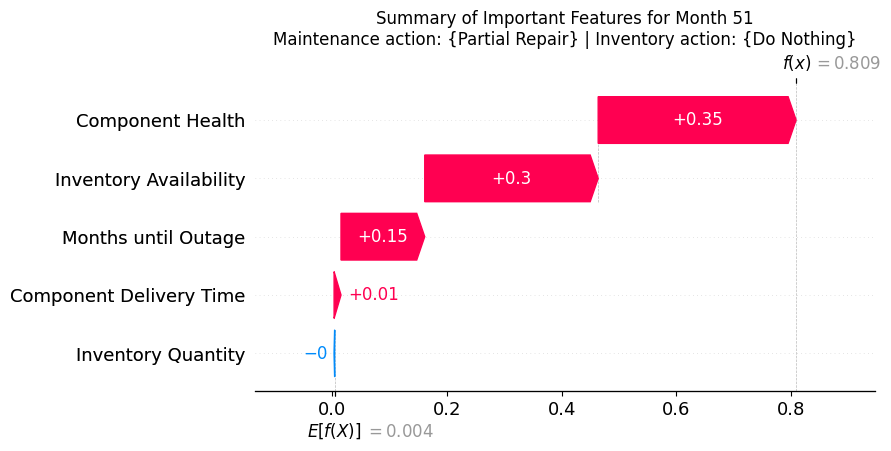

In [51]:
# Maintenance actions available [0,0; 1,0;  2,0;  0,1;  1,1;  2,1]
# Maintenance action (0 = nothing, 1 = partial repair, 2 = replace)
# Inventory action (0 = nothing, 1 = order component)


action_to_explain = 1
# Create a shap.Explanation object for the selected instance
explanation = shap.Explanation(values=shap_values[action_to_explain][instance_to_explain], base_values=explainer.expected_value[action_to_explain], feature_names=feature_names)

f = plt.figure()

# Create the SHAP waterfall plot
plt.title("Summary of Important Features for Month " + str(instance_to_explain)+ "\nMaintenance action: {Partial Repair} | Inventory action: {Do Nothing}")

shap.plots.waterfall(explanation)
f.savefig("SHAP_Waterfall_Act_1_instance_32_action_10.png", bbox_inches='tight', dpi=1200)

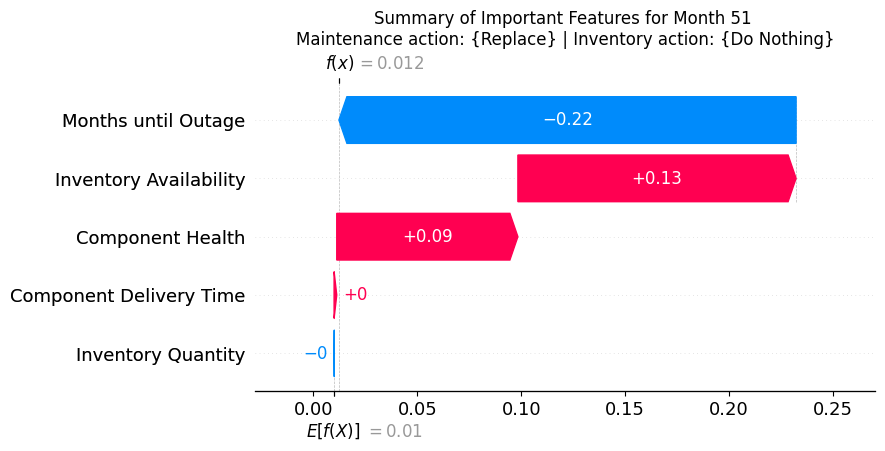

In [52]:
# Maintenance actions available [0,0; 1,0;  2,0;  0,1;  1,1;  2,1;]
# Maintenance action (0 = nothing, 1 = partial repair, 2 = replace)
# Inventory action (0 = nothing, 1 = order component)

action_to_explain = 2
# Create a shap.Explanation object for the selected instance
explanation = shap.Explanation(values=shap_values[action_to_explain][instance_to_explain], base_values=explainer.expected_value[action_to_explain], feature_names=feature_names)


f = plt.figure()

# Create the SHAP waterfall plot
plt.title("Summary of Important Features for Month " + str(instance_to_explain)+ " \nMaintenance action: {Replace} | Inventory action: {Do Nothing}")

shap.plots.waterfall(explanation)
f.savefig("SHAP_Waterfall_Act_2_instance_32_action_10.png", bbox_inches='tight', dpi=1200)

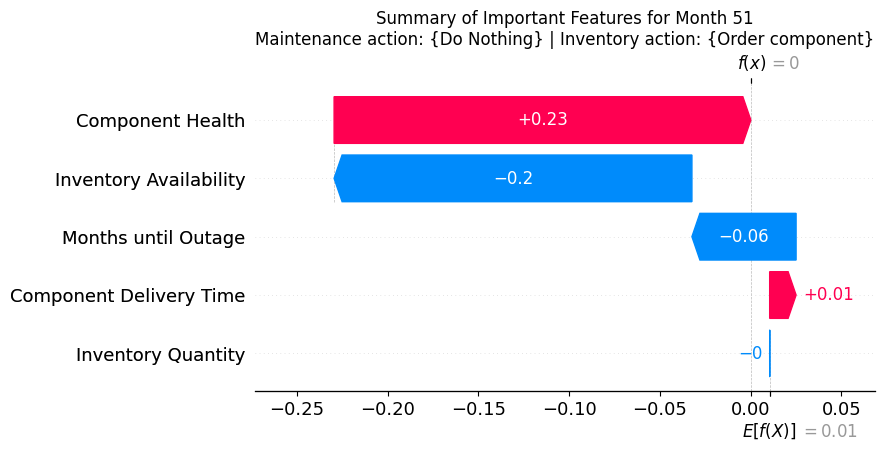

In [53]:
# Maintenance actions available [0,0; 1,0;  2,0;  0,1;  1,1;  2,1;]
# Maintenance action (0 = nothing, 1 = partial repair, 2 = replace)
# Inventory action (0 = nothing, 1 = order component)

action_to_explain = 3
# Create a shap.Explanation object for the selected instance
explanation = shap.Explanation(values=shap_values[action_to_explain][instance_to_explain], base_values=explainer.expected_value[action_to_explain], feature_names=feature_names)

f = plt.figure()

# Customize the plot here
plt.title("Summary of Important Features for Month " + str(instance_to_explain)+ "\nMaintenance action: {Do Nothing} | Inventory action: {Order component}")

shap.plots.waterfall(explanation)
f.savefig("SHAP_Waterfall_Act_3_instance_32_action_10.png", bbox_inches='tight', dpi=1200)

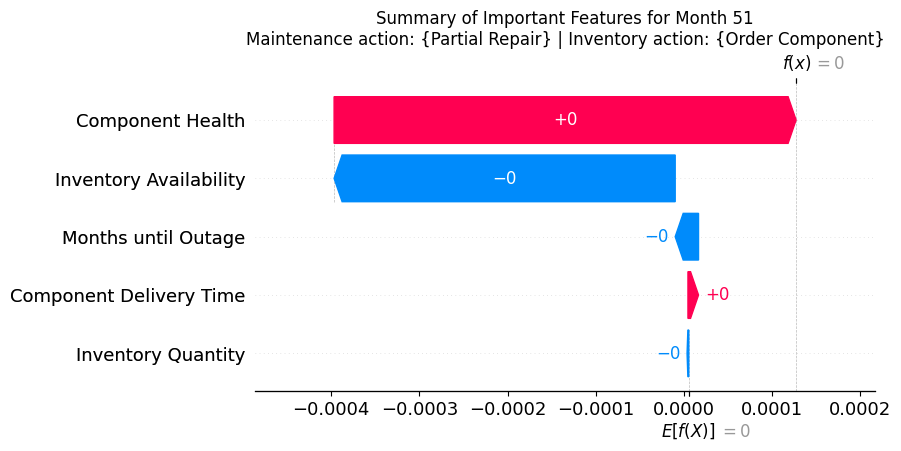

In [54]:
# Maintenance actions available [0,0; 1,0;  2,0;  0,1;  1,1;  2,1;]
# Maintenance action (0 = nothing, 1 = partial repair, 2 = replace)
# Inventory action (0 = nothing, 1 = order component)

action_to_explain = 4
# Create a shap.Explanation object for the selected instance
explanation = shap.Explanation(values=shap_values[action_to_explain][instance_to_explain], base_values=explainer.expected_value[action_to_explain], feature_names=feature_names)

f = plt.figure()

# Customize the plot here
plt.title("Summary of Important Features for Month " + str(instance_to_explain)+ "\nMaintenance action: {Partial Repair} | Inventory action: {Order Component}")

shap.plots.waterfall(explanation)
f.savefig("SHAP_Waterfall_Act_4_instance_32_action_10.png", bbox_inches='tight', dpi=1200)

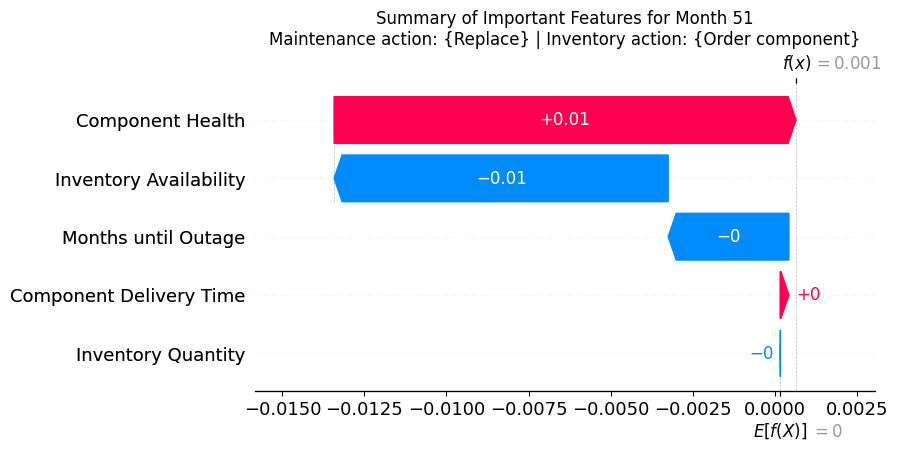

In [55]:
# Maintenance actions available [0,0; 1,0;  2,0;  0,1;  1,1;  2,1;]
# Maintenance action (0 = nothing, 1 = partial repair, 2 = replace)
# Inventory action (0 = nothing, 1 = order component)
action_to_explain = 5

# Create a shap.Explanation object for the selected instance
explanation = shap.Explanation(values=shap_values[action_to_explain][instance_to_explain], base_values=explainer.expected_value[action_to_explain], feature_names=feature_names)
f = plt.figure()
# Create the SHAP waterfall plot

# Customize the plot here
plt.title("Summary of Important Features for Month " + str(instance_to_explain) + "\nMaintenance action: {Replace} | Inventory action: {Order component}")

shap.plots.waterfall(explanation)
f.savefig("SHAP_Waterfall_Act_5_instance_32_action_10.png", bbox_inches='tight', dpi=1200)


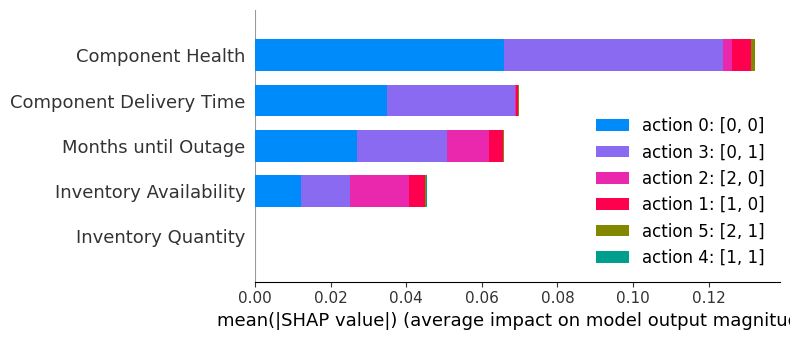

In [56]:
class_names = ["action 0: [0, 0]", "action 1: [1, 0]", "action 2: [2, 0]", "action 3: [0, 1]", "action 4: [1, 1]", "action 5: [2, 1]"]
shap.summary_plot(shap_values, feature_names=feature_names, class_names=class_names)


# add one instance

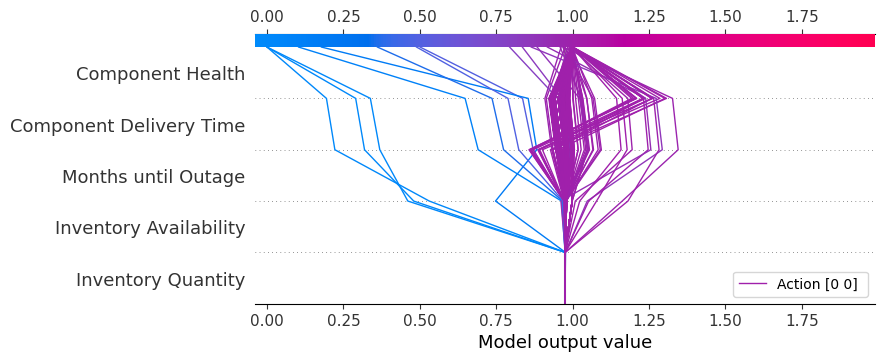

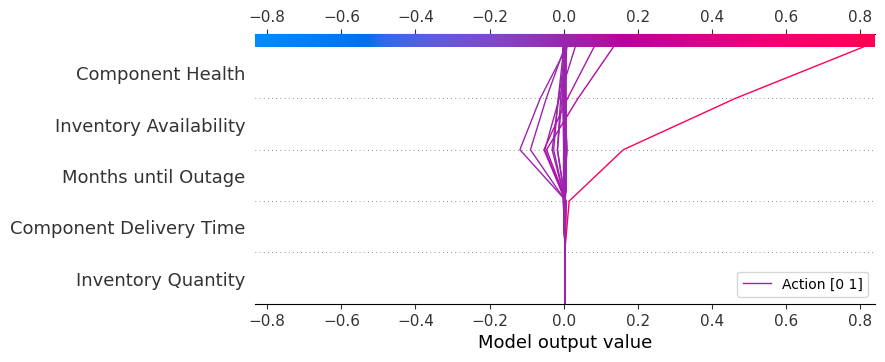

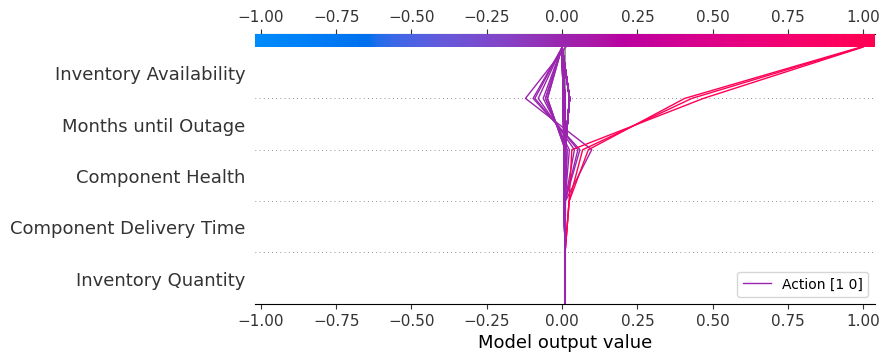

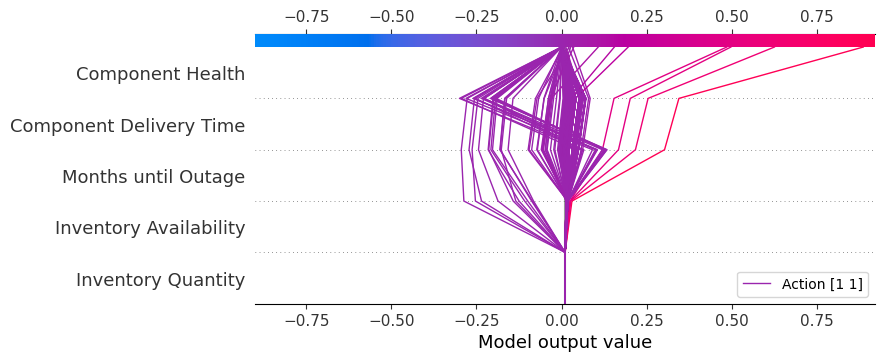

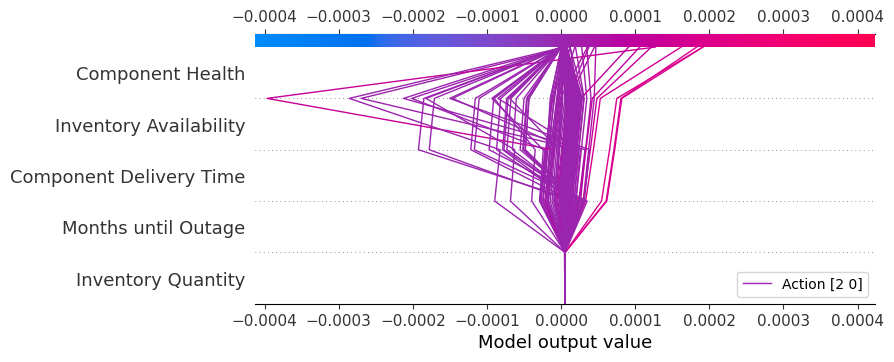

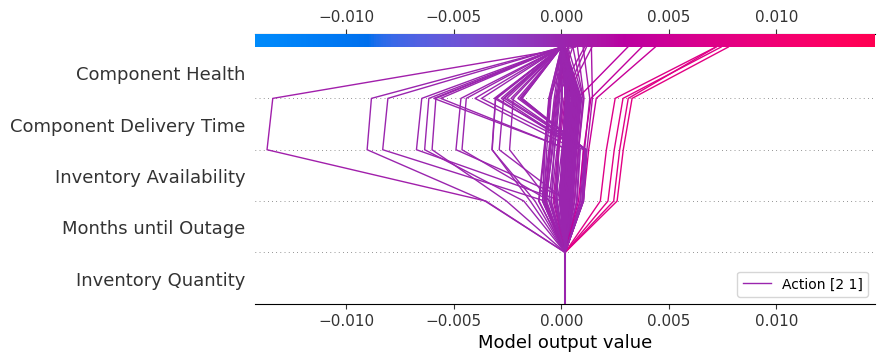

In [57]:
# class_names = ["Action 0: [0, 0]", "Action 1: [1, 0]", "Action 2: [2, 0]", "Action 3: [0, 1]", "Action 4: [1, 1]", "Action 5: [2, 1]"]
# class_names = ["Action 0", "Action 1", "Action 2", "Action 3", "Action 4", "Action 5"]
# [0,0; 0,1;  1,0;  1,1;  2,0;  2,1;]
class_names = ["Action [0 0] ", "Action [0 1]", "Action [1 0]", "Action [1 1]", "Action [2 0]", "Action [2 1]"]

for i in range(len(shap_values)):
  # shap.decision_plot(explainer.expected_value[i], shap_values[i], feature_names=feature_names, legend_labels=class_names[i], legend_location='lower right')
  shap.decision_plot(explainer.expected_value[i], shap_values[i], feature_names=feature_names, legend_labels=[class_names[i]], legend_location='lower right')


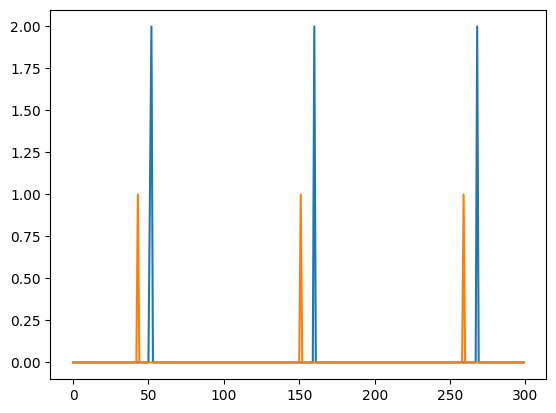

In [58]:
plt.plot(action_log)


Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.


(<Axes: ylabel='Observations'>,
 Text(0, 0.5, 'Observations'))

<Figure size 640x480 with 0 Axes>

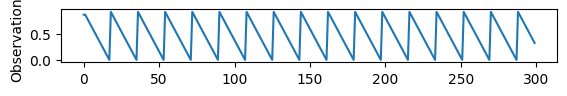

In [59]:
plt.figure()
axs = plt.subplots(sharex=True, sharey=False)

plt.subplot(611), plt.plot(state_log[:,0]), plt.ylabel('Observations')

In [60]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0], feature_names=feature_names,
                link='logit', matplotlib=False)

In [61]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][0], feature_names=feature_names,
                link='logit', matplotlib=False)

In [62]:
shap.initjs()
shap.force_plot(explainer.expected_value[2], shap_values[2][0], feature_names=feature_names,
                link='logit', matplotlib=False)

In [63]:
shap.initjs()
shap.force_plot(explainer.expected_value[3], shap_values[3][0], feature_names=feature_names,
                link='logit', matplotlib=False)

In [64]:
shap.initjs()
shap.force_plot(explainer.expected_value[4], shap_values[3][0], feature_names=feature_names,
                link='logit', matplotlib=False)

In [65]:
# Define the names of the states
feature_names=['Months until the Outage', 'Health of the Component', 'Inventory amount', 'Inventory Availability Flag', 'Component Delivery Time']

In [66]:
# import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt

env = Nuc_Maint_Env_Proposal_220211_NPIC_MATLAB2022A()

discount_factor = 0.999
max_steps_per_episode = 300

# Define the optimization algorithms for actor and critic networks
actor_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
critic_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

mtrx_max_act_idx = np.zeros((max_steps_per_episode, 2))
action_index_ = []
action_max_prob_ = []
actor = model_actorNet_env
critic = model_criticNet_env
state_tensors = []
episode_rewards = []
actionss = []
num_episodes = 1
for episode in range(num_episodes):
    state = env.reset()
    episode_reward = 0

    # with tf.GradientTape(persistent=True) as tape:
    for t in range(max_steps_per_episode):

        state_tensor = tf.convert_to_tensor(state)
        state_tensor_ = tf.expand_dims(state_tensor, 0)

        input_data = tf.cast(state_tensor_, dtype=tf.float32)
        # Create input tensor
        input_data = tf.constant(input_data, dtype=tf.float32)
        state_tensors.append(input_data)


        # Get action probabilities from actor network
        action_probs = actorNet_onnx_model.run(input_data)

        action_max_prob = np.array([action_probs])
        max_value = np.max(action_max_prob)
        action_max_prob_.append(max_value)

        # Sample an action from the action probabilities
        action_log_prob = tf.argmax(action_probs, axis=-1)
        # print(action_log_prob)
        action_index = action_log_prob.numpy().item()
        action_index_.append(action_index)



        # action_log_prob = torch.argmax(action_logits)
        actionelements = np.array([[0, 0], [1, 0], [2, 0], [0, 1], [1, 1], [2, 1]])


        # Retrieve the corresponding action

        action = actionelements[action_index]
        # action_max_prob =


        actionss.append(action)

        # Take the action in the environment
        state, reward, done, _ = env.step(action)

        episode_reward += reward
        episode_rewards.append(episode_reward)  # Save state_tensor to the list

        if done:
            break

    mtrx_max_act_idx[:,0] = action_max_prob_
    mtrx_max_act_idx[:,1] = action_index_
    state_log_ = tf.squeeze(state_tensors)
    action_log_ = tf.squeeze(actionss)
    state_log_ = np.array(state_log_)
    action_log_ = np.array(action_log_)

    state_log = np.array(state_tensors)
    action_log = np.array(actionss)

    t_values = np.arange(num_episodes)  # Generate an array of indices from 0 to max_steps_per_episode


Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.


(<Axes: ylabel='Observations'>,
 Text(0, 0.5, 'Observations'))

<Figure size 640x480 with 0 Axes>

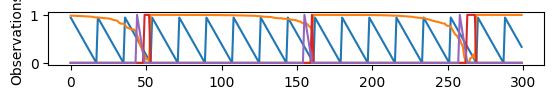

In [67]:
plt.figure()
axs = plt.subplots(sharex=True, sharey=False)

plt.subplot(611), plt.plot(state_log[:,0]), plt.ylabel('Observations')

In [68]:
state_log_reshaped = state_log.reshape(state_log.shape[0], -1)
explainer = shap.KernelExplainer(model_predict, state_log_reshaped)
shap_values = explainer.shap_values(state_log_reshaped)

  0%|          | 0/300 [00:00<?, ?it/s]

In [69]:
def explain(state_log_=state_log_reshaped, feature_names=feature_names, action_prob=model_predict(state_log_reshaped), cmap='coolwarm', save_fig=False):


    state_log_reshaped_min = state_log_reshaped.min()
    state_log_reshaped_max = state_log_reshaped.max()
    dot_size = 3
    state_log_re = state_log_*(state_log_reshaped_max - state_log_reshaped_min) + state_log_reshaped_min # rescale state log
    norm = plt.Normalize(vmin=-0.001, vmax=0.001) # define color scala between 0 and +2 (like the agents action space)
    actions = action_log_


    fig = plt.figure(figsize=(10,15))
    gs = fig.add_gridspec(8, hspace=0)
    axs = gs.subplots(sharex=True, sharey=False)

    for i in range(mtrx_max_act_idx.shape[0]):
        x_values = range(0, mtrx_max_act_idx.shape[0])
        y_values = mtrx_max_act_idx[:, 0]
        index = int(mtrx_max_act_idx[i, 1])
        axs[0].scatter(x_values, y_values, c=y_values - explainer.expected_value[index], cmap='coolwarm', norm=norm, s=dot_size)

    axs[0].set_ylabel('Agents Chosen Actions Probability', fontsize=6)
    axs[0].yaxis.set_label_position('right')

    axs[1].scatter(range(0, actions.shape[0]), actions[:,0], c=actions[:,0]- explainer.expected_value[0], cmap = cmap, norm=norm, s=dot_size)
    axs[1].set_ylabel('Maintenance  Action', fontsize=8)
    axs[1].yaxis.set_label_position('left')

    axs[2].scatter(range(0, actions.shape[0]), actions[:,1], c=actions[:,1]- explainer.expected_value[1], cmap = cmap, norm=norm, s=dot_size)
    axs[2].set_ylabel('Inventory Action', fontsize=8)
    axs[2].yaxis.set_label_position('right')

    axs[3].scatter(range(0,len(shap_values[0][:,4])), state_log_re[:,4], c=shap_values[0][:,4], cmap=cmap, norm=norm, s=dot_size)
    axs[3].set_ylabel(feature_names[4], fontsize=8)
    axs[3].yaxis.set_label_position('left')

    axs[4].scatter(range(0,len(shap_values[0][:,0])), state_log_re[:,0], c=shap_values[0][:,0], cmap=cmap, norm=norm, s=dot_size)
    axs[4].set_ylabel(feature_names[0], fontsize=8)
    axs[4].yaxis.set_label_position('right')

    axs[5].scatter(range(0,len(shap_values[0][:,1])), state_log_re[:,1], c=shap_values[0][:,1], cmap=cmap, norm=norm, s=dot_size)
    axs[5].set_ylabel(feature_names[1], fontsize=8)
    axs[5].yaxis.set_label_position('left')

    axs[6].scatter(range(0,len(shap_values[0][:,2])), state_log_re[:,2], c=shap_values[0][:,2], cmap=cmap, norm=norm, s=dot_size)
    axs[6].set_ylabel(feature_names[2], fontsize=8)
    axs[6].yaxis.set_label_position('right')

    axs[7].scatter(range(0,len(shap_values[0][:,3])), state_log_re[:,3], c=shap_values[0][:,3], cmap=cmap, norm=norm, s=dot_size)
    axs[7].set_ylabel(feature_names[3], fontsize=8)
    axs[7].yaxis.set_label_position('left')



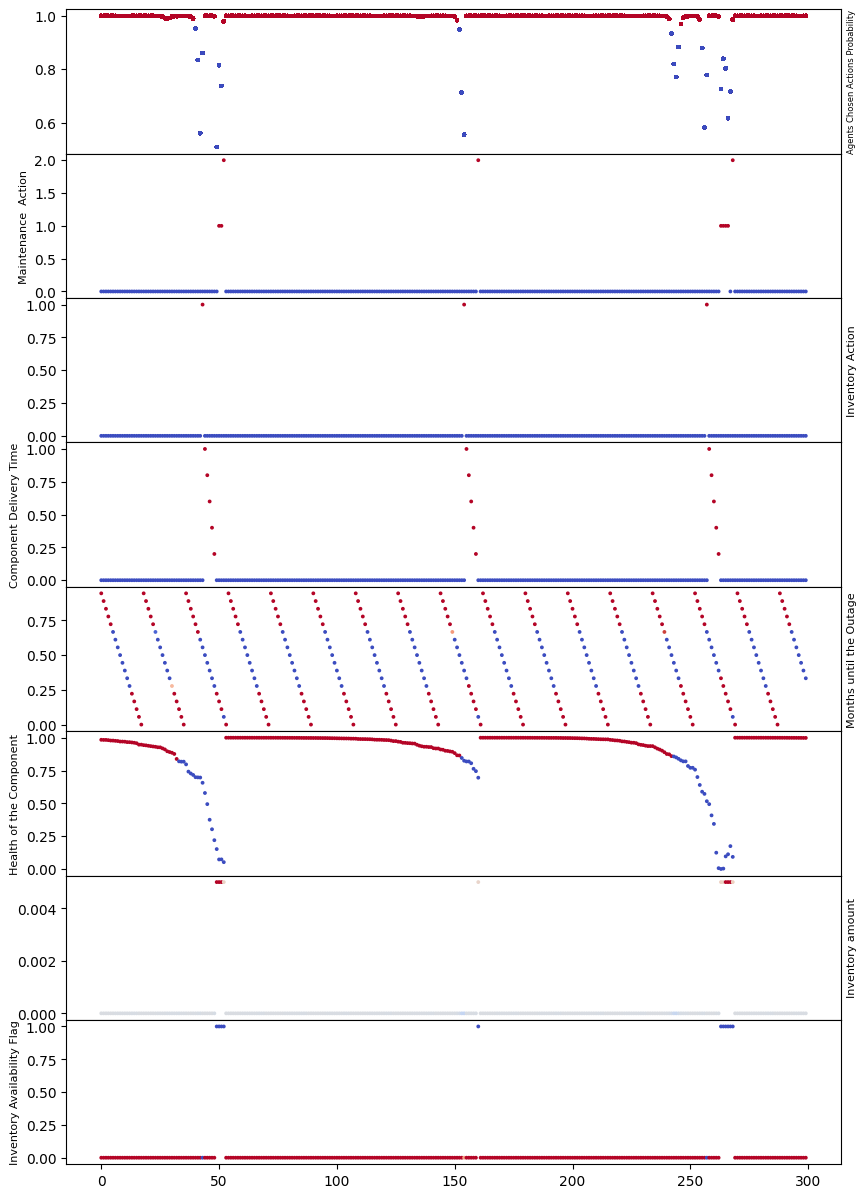

In [70]:
explain(state_log_reshaped, feature_names, model_predict(state_log_reshaped))

In [71]:
def explain(state_log_=state_log_reshaped, feature_names=feature_names, action_log_=model_predict(state_log_reshaped), cmap='coolwarm', save_fig=False):


    state_log_reshaped_min = state_log_reshaped.min()
    state_log_reshaped_max = state_log_reshaped.max()

    state_log_re = state_log_*(state_log_reshaped_max - state_log_reshaped_min) + state_log_reshaped_min # rescale state log
    action_log = action_log_
    norm = plt.Normalize(vmin=-0.001, vmax=0.001) # define color scala between 0 and +2 (like the agents action space)

    fig = plt.figure(figsize=(15,12))
    gs = fig.add_gridspec(6, hspace=0)
    axs = gs.subplots(sharex=True, sharey=False)
    axs[0].scatter(range(0, action_log.shape[0]), action_log[:,0], c=action_log[:,0]- explainer.expected_value[0], cmap = cmap, norm=norm)
    axs[0].set_ylabel('action_probability')
    axs[0].yaxis.set_label_position('right')
    axs[0].scatter(range(0, action_log.shape[0]), action_log[:,1], c=action_log[:,1]- explainer.expected_value[1], cmap = cmap, norm=norm)
    axs[0].set_ylabel('action_probability')
    axs[0].yaxis.set_label_position('right')
    axs[0].scatter(range(0, action_log.shape[0]), action_log[:,2], c=action_log[:,2]- explainer.expected_value[2], cmap = cmap, norm=norm)
    axs[0].set_ylabel('action_probability')
    axs[0].yaxis.set_label_position('right')
    axs[0].scatter(range(0, action_log.shape[0]), action_log[:,3], c=action_log[:,3]- explainer.expected_value[3], cmap = cmap, norm=norm)
    axs[0].set_ylabel('action_probability')
    axs[0].yaxis.set_label_position('right')
    axs[0].scatter(range(0, action_log.shape[0]), action_log[:,4], c=action_log[:,4]- explainer.expected_value[4], cmap = cmap, norm=norm)
    axs[0].set_ylabel('action_probability')
    axs[0].yaxis.set_label_position('right')
    axs[0].scatter(range(0, action_log.shape[0]), action_log[:,5], c=action_log[:,5]- explainer.expected_value[5], cmap = cmap, norm=norm)
    axs[0].set_ylabel('action_probability')
    axs[0].yaxis.set_label_position('right')
    axs[1].scatter(range(0,len(shap_values[0][:,4])), state_log_re[:,4], c=shap_values[0][:,4], cmap=cmap, norm=norm)
    axs[1].set_ylabel(feature_names[4])
    axs[1].yaxis.set_label_position('right')
    axs[2].scatter(range(0,len(shap_values[0][:,0])), state_log_re[:,0], c=shap_values[0][:,0], cmap=cmap, norm=norm)
    axs[2].set_ylabel(feature_names[0])
    axs[3].scatter(range(0,len(shap_values[0][:,1])), state_log_re[:,1], c=shap_values[0][:,1], cmap=cmap, norm=norm)
    axs[3].set_ylabel(feature_names[1])
    axs[3].yaxis.set_label_position('right')
    axs[4].scatter(range(0,len(shap_values[0][:,2])), state_log_re[:,2], c=shap_values[0][:,2], cmap=cmap, norm=norm)
    axs[4].set_ylabel(feature_names[2])
    axs[5].scatter(range(0,len(shap_values[0][:,3])), state_log_re[:,3], c=shap_values[0][:,3], cmap=cmap, norm=norm)
    axs[5].set_ylabel(feature_names[3])
    axs[5].yaxis.set_label_position('right')



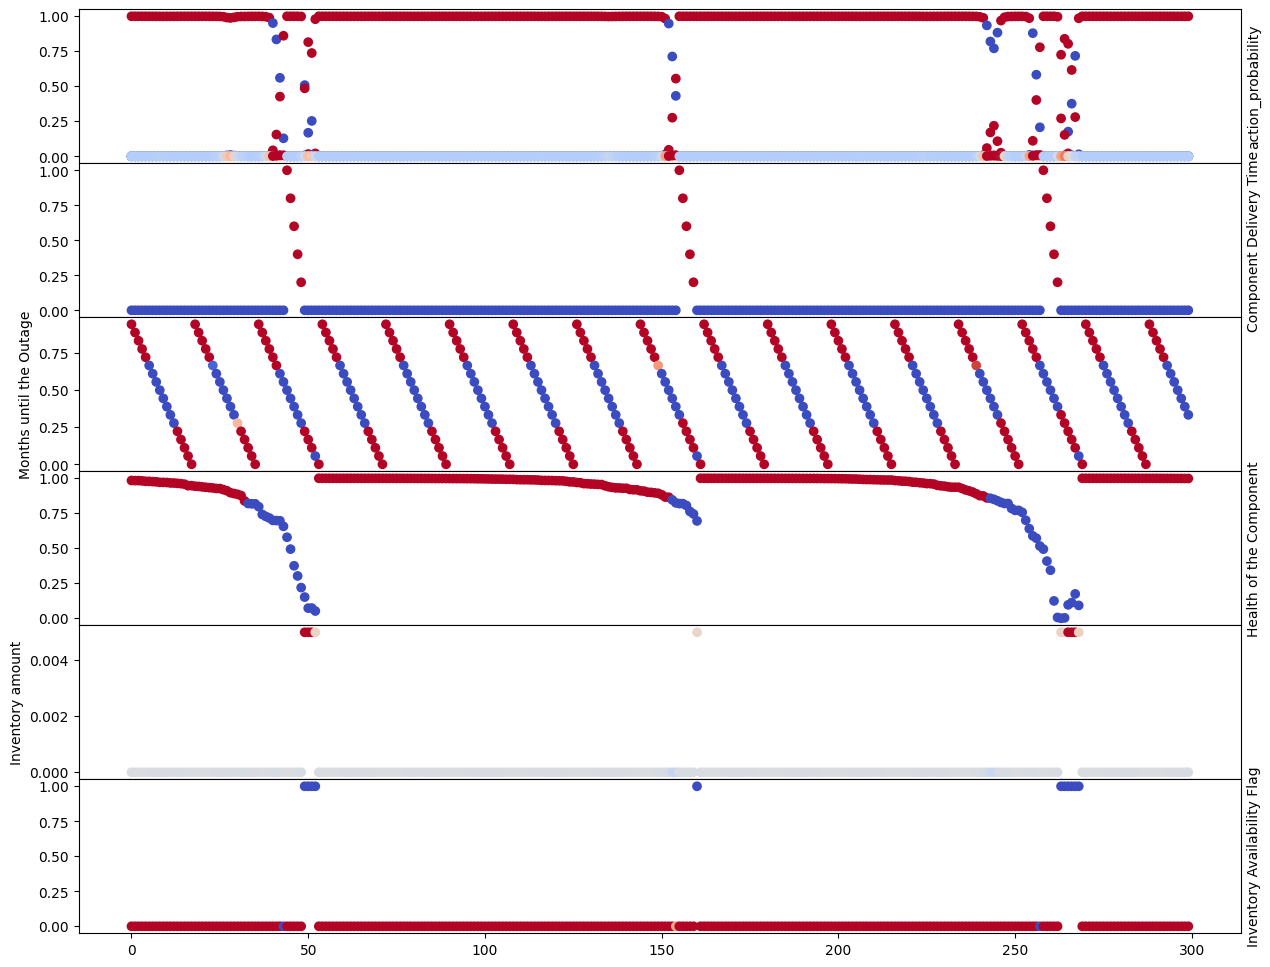

In [72]:
# output with shap values
explain(state_log_reshaped, feature_names, model_predict(state_log_reshaped))

In [73]:
len(action_max_prob_)

300

In [74]:
action_log_[:,0].shape

(300,)

In [75]:
def explain(state_log_=state_log_reshaped, feature_names=feature_names, action_prob=model_predict(state_log_reshaped), cmap='coolwarm', save_fig=False):


    state_log_reshaped_min = state_log_reshaped.min()
    state_log_reshaped_max = state_log_reshaped.max()

    state_log_re = state_log_*(state_log_reshaped_max - state_log_reshaped_min) + state_log_reshaped_min # rescale state log

    actions = action_log_
    state_log_re = state_log_*(state_log_reshaped_max - state_log_reshaped_min) + state_log_reshaped_min # rescale state log

    norm = plt.Normalize(vmin=-0.001, vmax=0.001) # define color scala between 0 and +2 (like the agents action space)

    fig = plt.figure(figsize=(15,12))
    gs = fig.add_gridspec(8, hspace=0)
    axs = gs.subplots(sharex=True, sharey=False)
    axs[0].scatter(range(0, action_prob.shape[0]), action_prob[:,0], c=action_prob[:,0]- explainer.expected_value[0], cmap = cmap, norm=norm)
    axs[0].set_ylabel('action_probability')
    axs[0].yaxis.set_label_position('right')
    axs[0].scatter(range(0, action_prob.shape[0]), action_prob[:,1], c=action_prob[:,1]- explainer.expected_value[1], cmap = cmap, norm=norm)
    axs[0].set_ylabel('action_probability')
    axs[0].yaxis.set_label_position('right')
    axs[0].scatter(range(0, action_prob.shape[0]), action_prob[:,2], c=action_prob[:,2]- explainer.expected_value[2], cmap = cmap, norm=norm)
    axs[0].set_ylabel('action_probability')
    axs[0].yaxis.set_label_position('right')
    axs[0].scatter(range(0, action_prob.shape[0]), action_prob[:,3], c=action_prob[:,3]- explainer.expected_value[3], cmap = cmap, norm=norm)
    axs[0].set_ylabel('action_probability')
    axs[0].yaxis.set_label_position('right')
    axs[0].scatter(range(0, action_prob.shape[0]), action_prob[:,4], c=action_prob[:,4]- explainer.expected_value[4], cmap = cmap, norm=norm)
    axs[0].set_ylabel('action_probability')
    axs[0].yaxis.set_label_position('right')
    axs[0].scatter(range(0, action_prob.shape[0]), action_prob[:,5], c=action_prob[:,5]- explainer.expected_value[5], cmap = cmap, norm=norm)
    axs[0].set_ylabel('action_probability')
    axs[0].yaxis.set_label_position('right')

    axs[1].scatter(range(0, actions.shape[0]), actions[:,0], c=actions[:,0]- explainer.expected_value[0], cmap = cmap, norm=norm)
    axs[1].set_ylabel('Maint act')
    axs[1].yaxis.set_label_position('left')

    axs[2].scatter(range(0, actions.shape[0]), actions[:,1], c=actions[:,1]- explainer.expected_value[1], cmap = cmap, norm=norm)
    axs[2].set_ylabel('Inv act')
    axs[2].yaxis.set_label_position('right')

    axs[3].scatter(range(0,len(shap_values[0][:,4])), state_log_re[:,4], c=shap_values[0][:,4], cmap=cmap, norm=norm)
    axs[3].set_ylabel(feature_names[4])

    axs[4].scatter(range(0,len(shap_values[0][:,0])), state_log_re[:,0], c=shap_values[0][:,0], cmap=cmap, norm=norm)
    axs[4].set_ylabel(feature_names[0])
    axs[4].yaxis.set_label_position('right')

    axs[5].scatter(range(0,len(shap_values[0][:,1])), state_log_re[:,1], c=shap_values[0][:,1], cmap=cmap, norm=norm)
    axs[5].set_ylabel(feature_names[1])

    axs[6].scatter(range(0,len(shap_values[0][:,2])), state_log_re[:,2], c=shap_values[0][:,2], cmap=cmap, norm=norm)
    axs[6].set_ylabel(feature_names[2])
    axs[6].yaxis.set_label_position('right')

    axs[7].scatter(range(0,len(shap_values[0][:,3])), state_log_re[:,3], c=shap_values[0][:,3], cmap=cmap, norm=norm)
    axs[7].set_ylabel(feature_names[3])



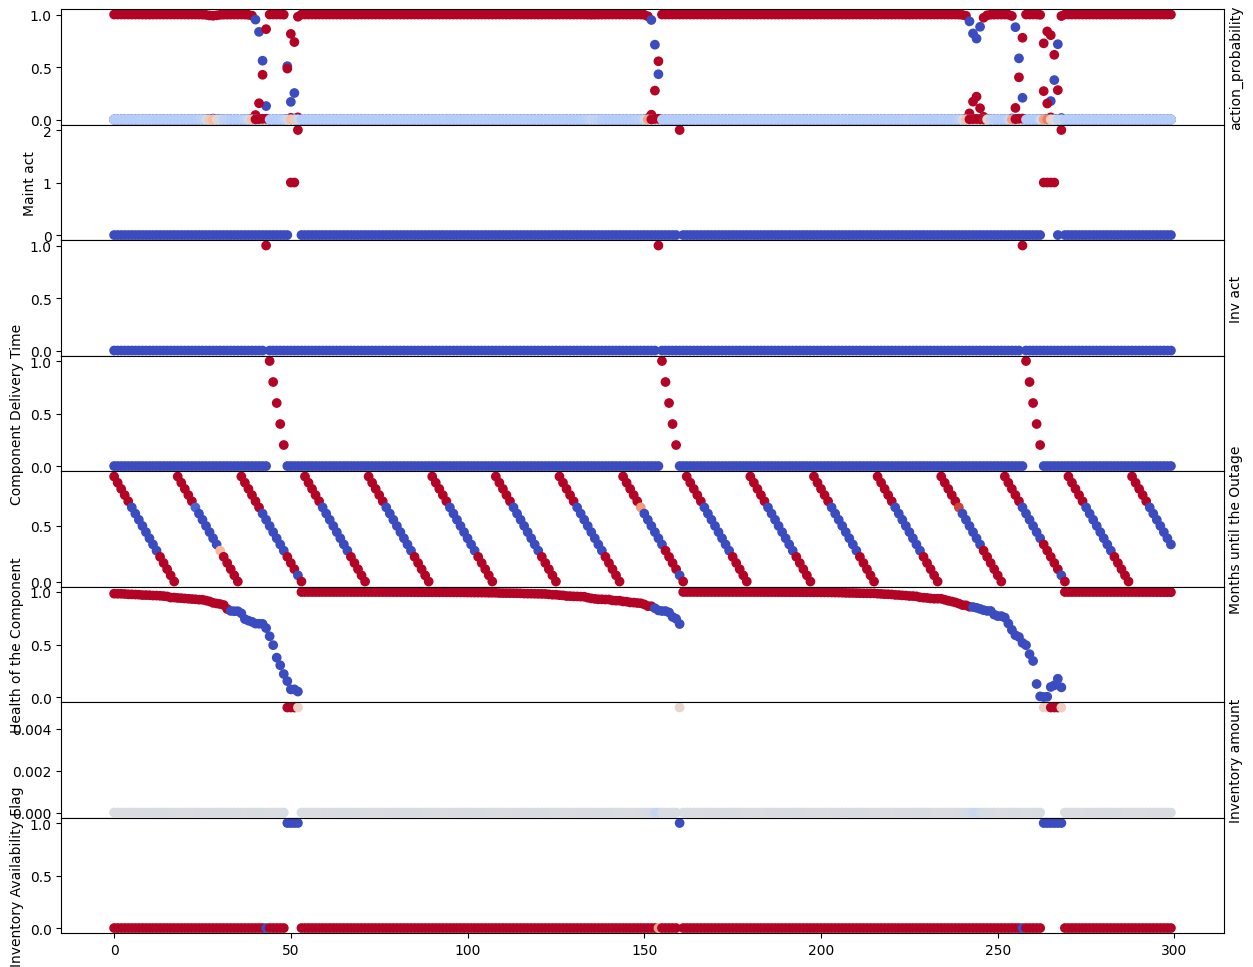

In [76]:
# output with shap values
explain(state_log_, feature_names, model_predict(state_log_reshaped))

In [77]:
def explain(state_log_=state_log_reshaped, feature_names=feature_names, action_prob=model_predict(state_log_reshaped), cmap='coolwarm', save_fig=False):


    state_log_reshaped_min = state_log_reshaped.min()
    state_log_reshaped_max = state_log_reshaped.max()

    state_log_re = state_log_*(state_log_reshaped_max - state_log_reshaped_min) + state_log_reshaped_min # rescale state log

    actions = action_log_
    state_log_re = state_log_*(state_log_reshaped_max - state_log_reshaped_min) + state_log_reshaped_min # rescale state log

    norm = plt.Normalize(vmin=-0.001, vmax=0.001) # define color scala between 0 and +2 (like the agents action space)

    fig = plt.figure(figsize=(20,18))
    gs = fig.add_gridspec(13, hspace=0)
    axs = gs.subplots(sharex=True, sharey=False)
    axs[0].scatter(range(0, action_prob.shape[0]), action_prob[:,0], c=action_prob[:,0]- explainer.expected_value[0], cmap = cmap, norm=norm)
    axs[0].set_ylabel('action_prob_[00]')
    axs[0].yaxis.set_label_position('right')


    axs[1].scatter(range(0, action_prob.shape[0]), action_prob[:,1], c=action_prob[:,1]- explainer.expected_value[1], cmap = cmap, norm=norm)
    axs[1].set_ylabel('action_probab[]')
    axs[1].yaxis.set_label_position('left')

    axs[2].scatter(range(0, action_prob.shape[0]), action_prob[:,2], c=action_prob[:,2]- explainer.expected_value[2], cmap = cmap, norm=norm)
    axs[2].set_ylabel('action_probability')
    axs[2].yaxis.set_label_position('right')

    axs[3].scatter(range(0, action_prob.shape[0]), action_prob[:,3], c=action_prob[:,3]- explainer.expected_value[3], cmap = cmap, norm=norm)
    axs[3].set_ylabel('action_probability')
    axs[3].yaxis.set_label_position('left')

    axs[4].scatter(range(0, action_prob.shape[0]), action_prob[:,4], c=action_prob[:,4]- explainer.expected_value[4], cmap = cmap, norm=norm)
    axs[4].set_ylabel('action_probability')
    axs[4].yaxis.set_label_position('right')

    axs[5].scatter(range(0, action_prob.shape[0]), action_prob[:,5], c=action_prob[:,5]- explainer.expected_value[5], cmap = cmap, norm=norm)
    axs[5].set_ylabel('action_probability')
    axs[5].yaxis.set_label_position('left')

    axs[6].scatter(range(0, actions.shape[0]), actions[:,0], c=actions[:,0]- explainer.expected_value[0], cmap = cmap, norm=norm)
    axs[6].set_ylabel('Maint  act')
    axs[6].yaxis.set_label_position('left')

    axs[7].scatter(range(0, actions.shape[0]), actions[:,1], c=actions[:,1]- explainer.expected_value[1], cmap = cmap, norm=norm)
    axs[7].set_ylabel('Inv act')
    axs[7].yaxis.set_label_position('right')

    axs[8].scatter(range(0,len(shap_values[0][:,4])), state_log_re[:,4], c=shap_values[0][:,4], cmap=cmap, norm=norm)
    axs[8].set_ylabel(feature_names[4])

    axs[9].scatter(range(0,len(shap_values[0][:,0])), state_log_re[:,0], c=shap_values[0][:,0], cmap=cmap, norm=norm)
    axs[9].set_ylabel(feature_names[0])
    axs[9].yaxis.set_label_position('right')

    axs[10].scatter(range(0,len(shap_values[0][:,1])), state_log_re[:,1], c=shap_values[0][:,1], cmap=cmap, norm=norm)
    axs[10].set_ylabel(feature_names[1])

    axs[11].scatter(range(0,len(shap_values[0][:,2])), state_log_re[:,2], c=shap_values[0][:,2], cmap=cmap, norm=norm)
    axs[11].set_ylabel(feature_names[2])
    axs[11].yaxis.set_label_position('right')

    axs[12].scatter(range(0,len(shap_values[0][:,3])), state_log_re[:,3], c=shap_values[0][:,3], cmap=cmap, norm=norm)
    axs[12].set_ylabel(feature_names[3])





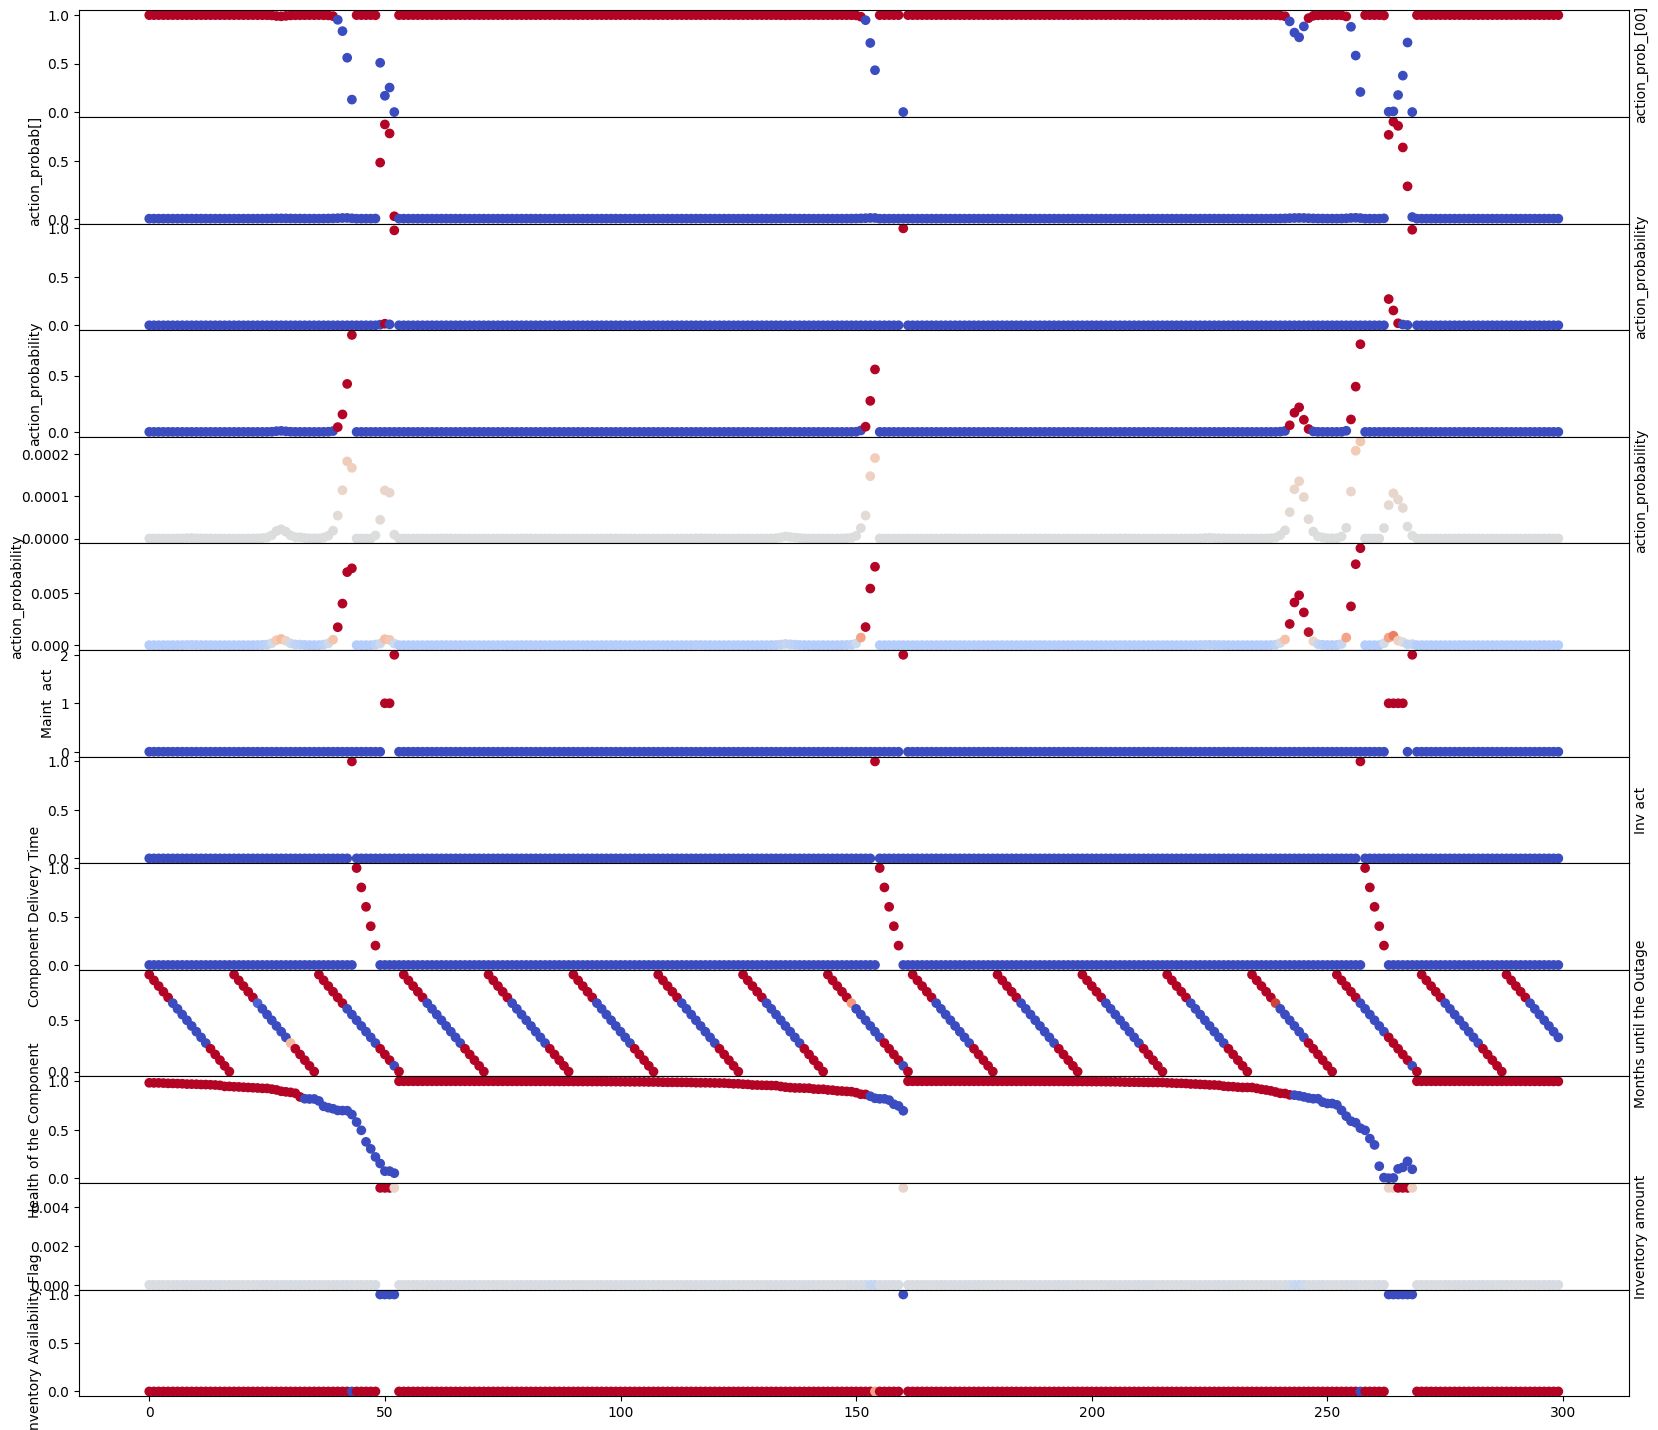

In [78]:
# output with shap values
explain(state_log_, feature_names, model_predict(state_log_reshaped))

In [79]:
explainer.expected_value

array([9.55567673e-01, 1.82846935e-02, 1.15001511e-02, 1.43671325e-02,
       9.57889344e-06, 2.70758293e-04])

In [80]:
len(action_max_prob_)

300

In [81]:
def explain(state_log_=state_log_reshaped, feature_names=feature_names, action_prob=model_predict(state_log_reshaped), cmap='coolwarm', save_fig=False):


    state_log_reshaped_min = state_log_reshaped.min()
    state_log_reshaped_max = state_log_reshaped.max()

    state_log_re = state_log_*(state_log_reshaped_max - state_log_reshaped_min) + state_log_reshaped_min # rescale state log

    actions = action_log_
    state_log_re = state_log_*(state_log_reshaped_max - state_log_reshaped_min) + state_log_reshaped_min # rescale state log

    norm = plt.Normalize(vmin=-0.001, vmax=0.001) # define color scala between 0 and +2 (like the agents action space)

    fig = plt.figure(figsize=(20,18))
    gs = fig.add_gridspec(13, hspace=0)
    axs = gs.subplots(sharex=True, sharey=False)
    axs[0].scatter(range(0, action_prob.shape[0]), action_prob[:,0], c=action_prob[:,0]- explainer.expected_value[0], cmap = cmap, norm=norm)
    axs[0].set_ylabel('action_prob_[00]')
    axs[0].yaxis.set_label_position('right')


    axs[1].scatter(range(0, action_prob.shape[0]), action_prob[:,1], c=action_prob[:,1]- explainer.expected_value[1], cmap = cmap, norm=norm)
    axs[1].set_ylabel('action_probab[]')
    axs[1].yaxis.set_label_position('left')

    axs[2].scatter(range(0, action_prob.shape[0]), action_prob[:,2], c=action_prob[:,2]- explainer.expected_value[2], cmap = cmap, norm=norm)
    axs[2].set_ylabel('action_probability')
    axs[2].yaxis.set_label_position('right')

    axs[3].scatter(range(0, action_prob.shape[0]), action_prob[:,3], c=action_prob[:,3]- explainer.expected_value[3], cmap = cmap, norm=norm)
    axs[3].set_ylabel('action_probability')
    axs[3].yaxis.set_label_position('left')

    axs[4].scatter(range(0, action_prob.shape[0]), action_prob[:,4], c=action_prob[:,4]- explainer.expected_value[4], cmap = cmap, norm=norm)
    axs[4].set_ylabel('action_probability')
    axs[4].yaxis.set_label_position('right')

    axs[5].scatter(range(0, action_prob.shape[0]), action_prob[:,5], c=action_prob[:,5]- explainer.expected_value[5], cmap = cmap, norm=norm)
    axs[5].set_ylabel('action_probability')
    axs[5].yaxis.set_label_position('left')

    axs[6].scatter(range(0, actions.shape[0]), actions[:,0], c=actions[:,0]- explainer.expected_value[0], cmap = cmap, norm=norm)
    axs[6].set_ylabel('Maint  act')
    axs[6].yaxis.set_label_position('left')

    axs[7].scatter(range(0, actions.shape[0]), actions[:,1], c=actions[:,1]- explainer.expected_value[1], cmap = cmap, norm=norm)
    axs[7].set_ylabel('Inv act')
    axs[7].yaxis.set_label_position('right')

    axs[8].scatter(range(0,len(shap_values[0][:,4])), state_log_re[:,4], c=shap_values[0][:,4], cmap=cmap, norm=norm)
    axs[8].set_ylabel(feature_names[4])

    axs[9].scatter(range(0,len(shap_values[0][:,0])), state_log_re[:,0], c=shap_values[0][:,0], cmap=cmap, norm=norm)
    axs[9].set_ylabel(feature_names[0])
    axs[9].yaxis.set_label_position('right')

    axs[10].scatter(range(0,len(shap_values[0][:,1])), state_log_re[:,1], c=shap_values[0][:,1], cmap=cmap, norm=norm)
    axs[10].set_ylabel(feature_names[1])

    axs[11].scatter(range(0,len(shap_values[0][:,2])), state_log_re[:,2], c=shap_values[0][:,2], cmap=cmap, norm=norm)
    axs[11].set_ylabel(feature_names[2])
    axs[11].yaxis.set_label_position('right')

    axs[12].scatter(range(0,len(shap_values[0][:,3])), state_log_re[:,3], c=shap_values[0][:,3], cmap=cmap, norm=norm)
    axs[12].set_ylabel(feature_names[3])





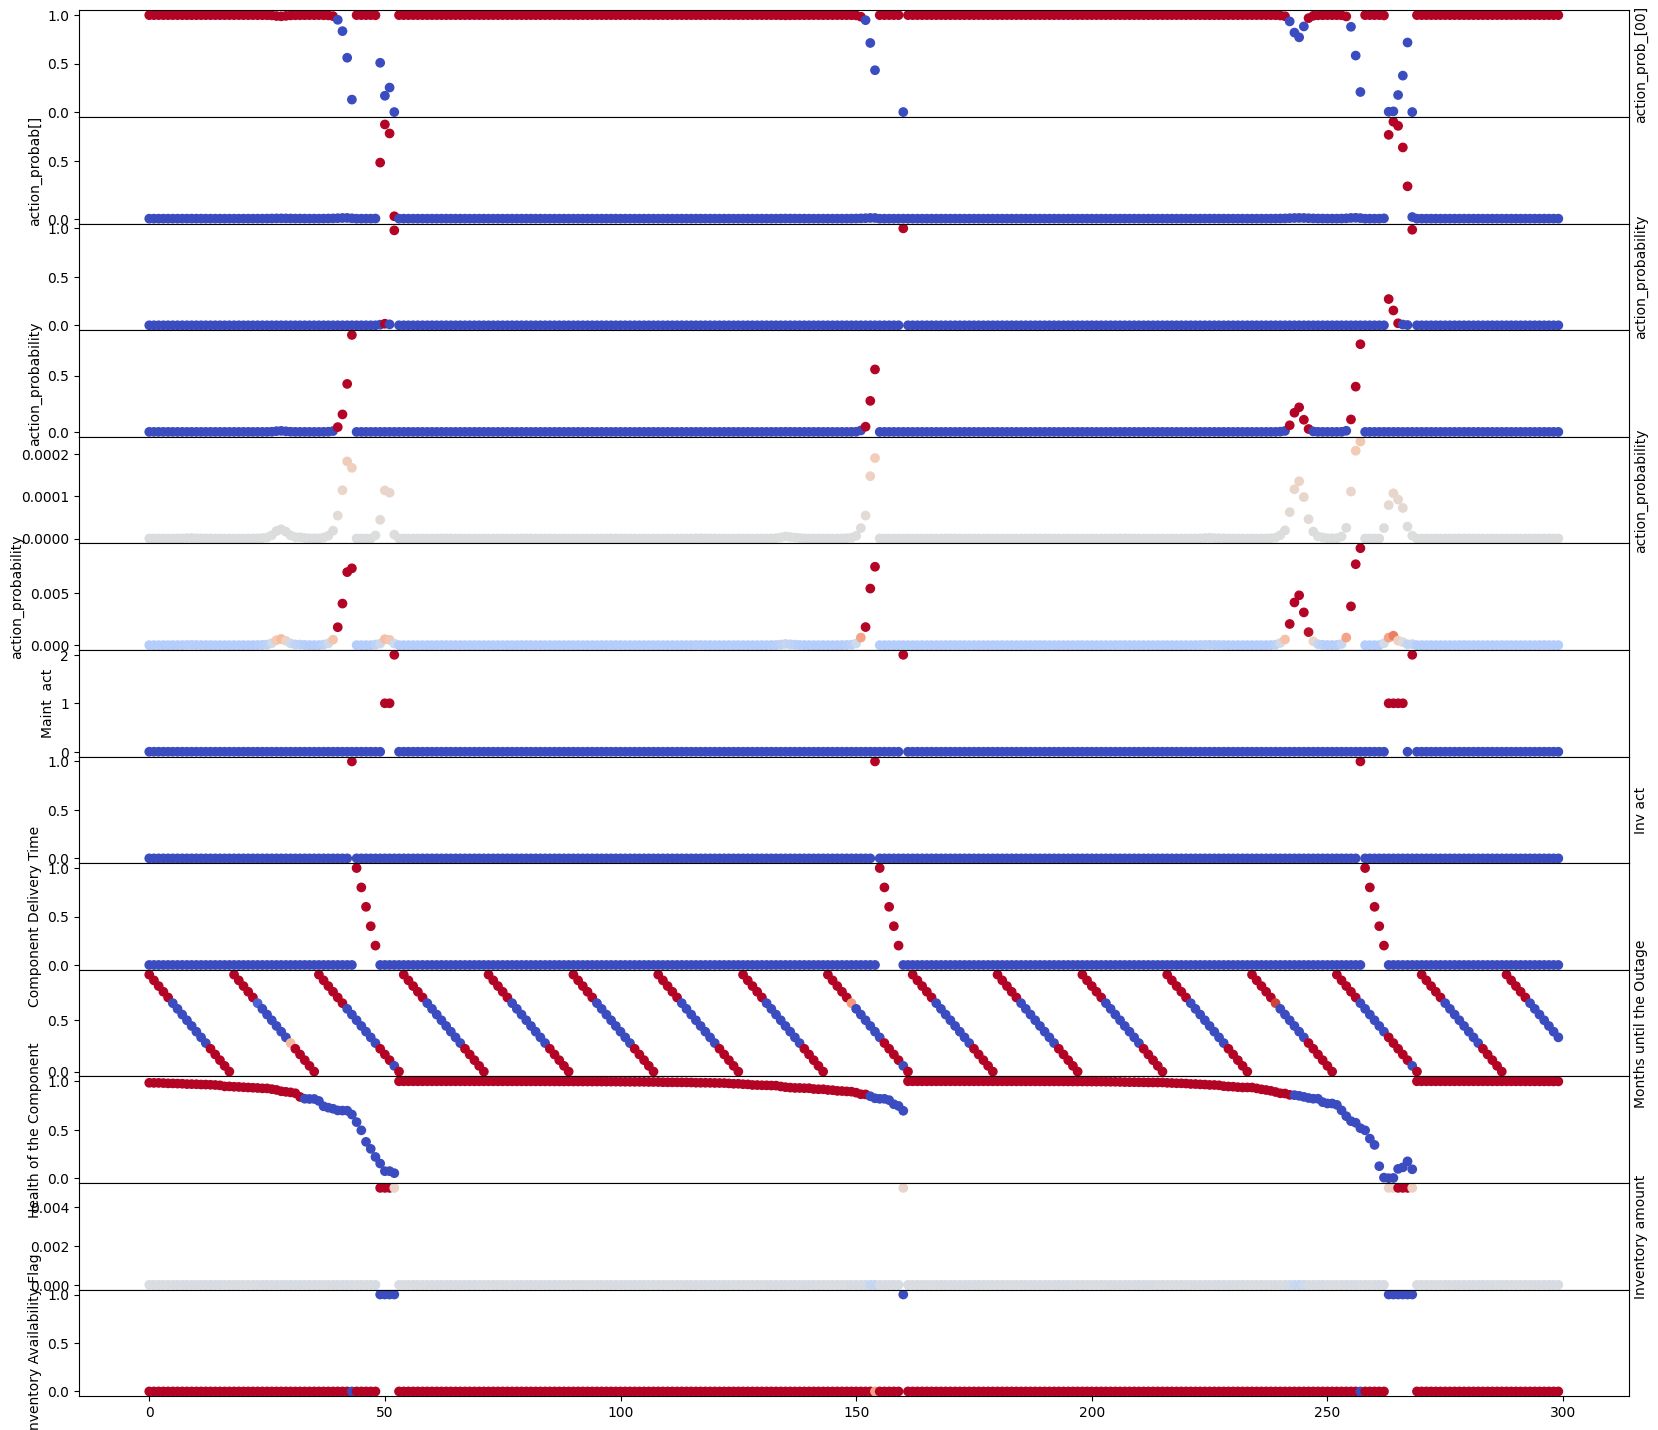

In [82]:
# output with shap values
explain(state_log_, feature_names, model_predict(state_log_reshaped))

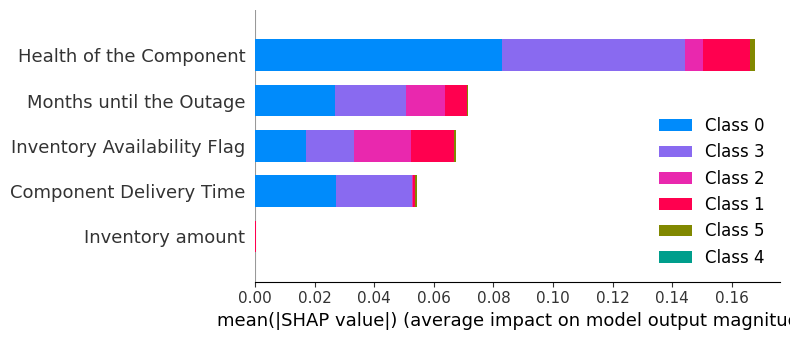

In [83]:
shap.summary_plot(shap_values, feature_names=feature_names)

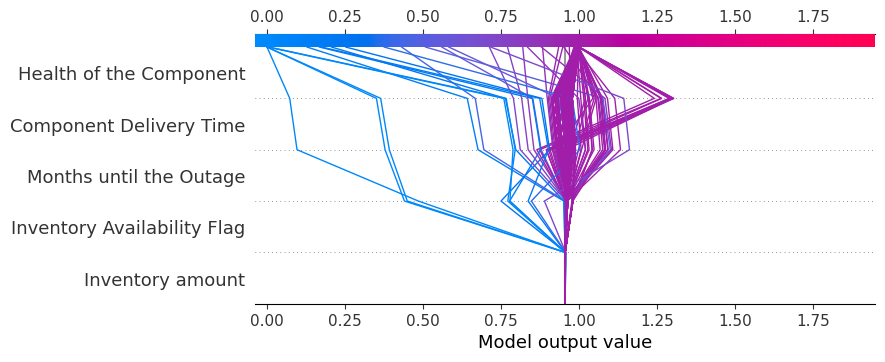

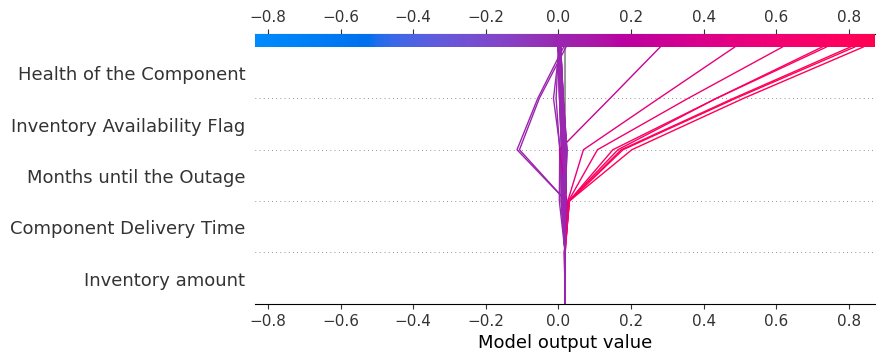

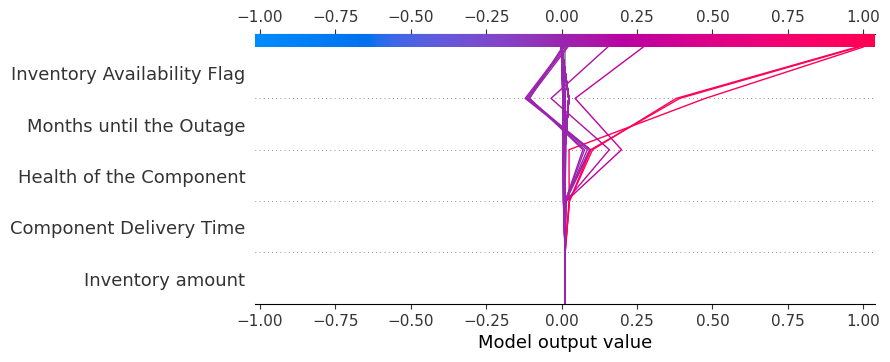

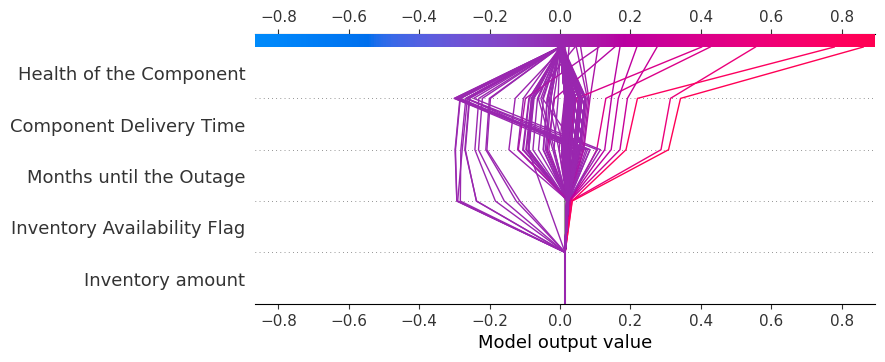

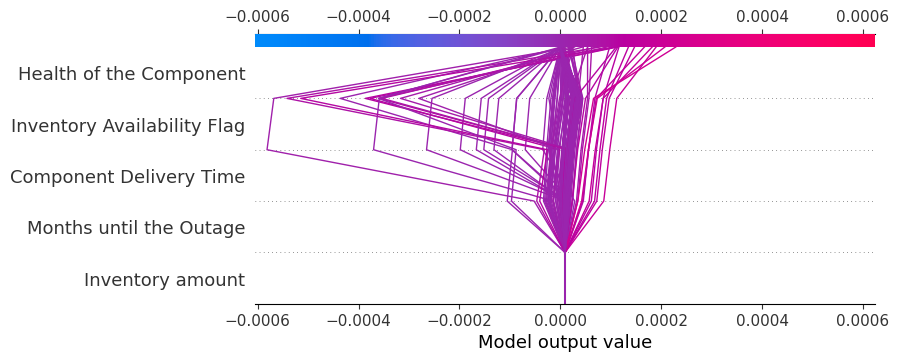

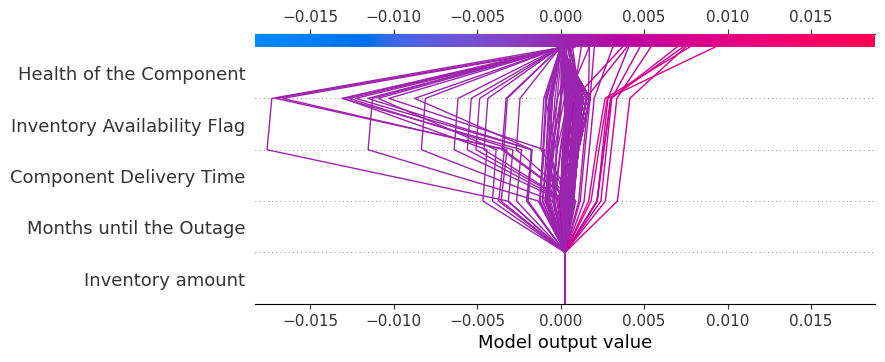

In [84]:
for i in range(len(shap_values)):
  shap.decision_plot(explainer.expected_value[i], shap_values[i], feature_names=feature_names)


In [85]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][0], feature_names=feature_names,
                link='logit', matplotlib=False)

In [86]:
shap.initjs()
shap.force_plot(explainer.expected_value[2], shap_values[2][0], feature_names=feature_names,
                link='logit', matplotlib=False)

In [87]:
shap.initjs()
shap.force_plot(explainer.expected_value[3], shap_values[3][0], feature_names=feature_names,
                link='logit', matplotlib=False)

In [88]:
shap.initjs()
shap.force_plot(explainer.expected_value[4], shap_values[3][0], feature_names=feature_names,
                link='logit', matplotlib=False)

In [89]:
shap_values_ = np.array(shap_values)
print(shap_values_.shape)
shap_values_ = np.array(shap_values[1])
print(shap_values_.shape)


(6, 300, 5)
(300, 5)


In [90]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], feature_names=feature_names,
                link='logit', matplotlib=False)

In [91]:
explainer_critic = shap.KernelExplainer(model_criticNet, state_log_)
shap_values_critic = explainer.shap_values(state_log_) # Calculate shap values

  0%|          | 0/300 [00:00<?, ?it/s]

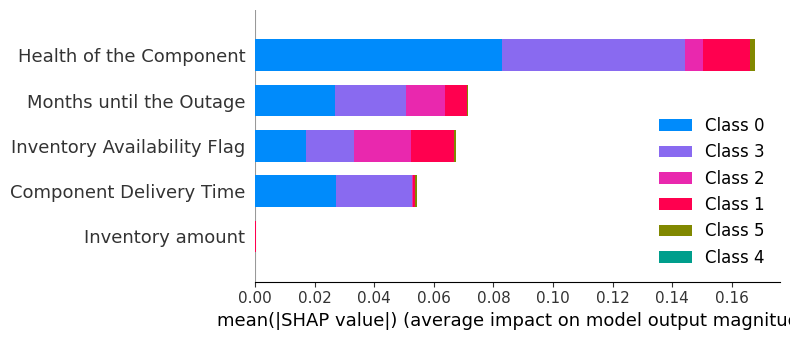

In [92]:
shap.summary_plot(shap_values_critic, feature_names=feature_names)

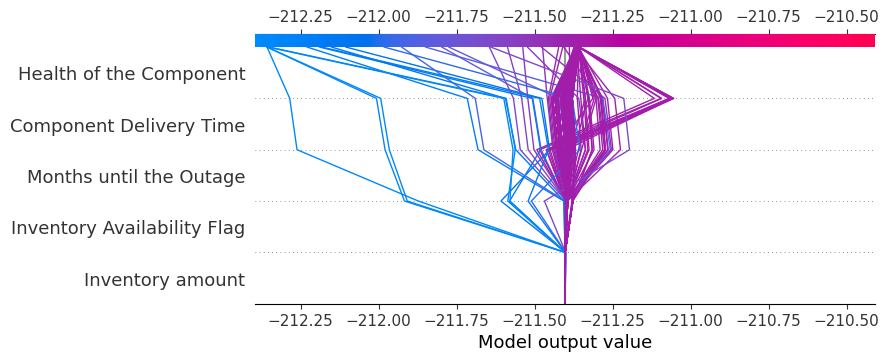

In [93]:
shap.decision_plot(explainer_critic.expected_value[0], shap_values_critic[0], feature_names=feature_names)


